In [1]:
import tensorflow as tf

import numpy as np

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.layers import Activation, Dense, Dropout
from tensorflow.keras import optimizers
from pandas import Series
import math
import numpy
from tensorflow.keras.layers import *
from tensorflow.keras import layers
import pandas as pd

#data = pd.read_csv('bitcoin.csv')
data = pd.read_csv('bitcoin2000.csv')

In [3]:
data.set_index(['timeUTC'],inplace=True)
#data = data['item_cnt_day'].resample('D').sum()
df=pd.DataFrame(data)

In [4]:
len(data)

10005

In [5]:
class CharacterTable(object):
    def __init__(self, chars):
        """Initialize character table.
        # Arguments
            chars: Characters that can appear in the input.
        """
        self.chars = sorted(set(chars))
        self.char_indices = dict((c, i) for i, c in enumerate(self.chars))
        self.indices_char = dict((i, c) for i, c in enumerate(self.chars))

    def encode(self, C, num_rows):
        """One hot encode given string C.
        # Arguments
            num_rows: Number of rows in the returned one hot encoding. This is
                used to keep the # of rows for each data the same.
        """
        x = np.zeros((num_rows, len(self.chars)))
        for i, c in enumerate(C):
            x[i, self.char_indices[c]] = 1
        return x

    def decode(self, x, calc_argmax=True):
        if calc_argmax:
            x = x.argmax(axis=-1)
        return ''.join(self.indices_char[x] for x in x)

In [6]:
from sklearn.preprocessing import MinMaxScaler
values = data[['close','high','low','open']].values.reshape(-1,4)
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [7]:
np.max(values)

41964.96

In [8]:
train_size = int(len(scaled) * 0.80)
val_size = int(len(scaled) * 0.10)

test_size = len(scaled) - train_size-val_size
train,val, test = scaled[0:train_size,:],scaled[train_size:train_size+val_size,:], scaled[train_size+val_size:,:]
print(len(train),len(val), len(test))

8004 1000 1001


In [9]:
def create_dataset_mul(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    print(len(dataY))
    return np.array(dataX), np.array(dataY)

In [10]:
look_back = 12
trainX, trainY = create_dataset_mul(train, look_back)
valX, valY = create_dataset_mul(val, look_back)
testX, testY = create_dataset_mul(test, look_back)

7992
988
989


In [47]:
trainX

array([[[0.07853526, 0.06953334, 0.08642124, 0.07864372],
        [0.07943861, 0.06922349, 0.08687709, 0.07853526],
        [0.07944345, 0.06960029, 0.08765591, 0.07943861],
        ...,
        [0.07993981, 0.06983193, 0.08803181, 0.08011162],
        [0.08107056, 0.07072825, 0.08815738, 0.07993981],
        [0.0797825 , 0.07078021, 0.08794431, 0.08107056]],

       [[0.07943861, 0.06922349, 0.08687709, 0.07853526],
        [0.07944345, 0.06960029, 0.08765591, 0.07943861],
        [0.07948129, 0.0693156 , 0.08745121, 0.07944345],
        ...,
        [0.08107056, 0.07072825, 0.08815738, 0.07993981],
        [0.0797825 , 0.07078021, 0.08794431, 0.08107056],
        [0.07956746, 0.06960671, 0.08772855, 0.0797825 ]],

       [[0.07944345, 0.06960029, 0.08765591, 0.07943861],
        [0.07948129, 0.0693156 , 0.08745121, 0.07944345],
        [0.07873285, 0.06978213, 0.08652089, 0.07948129],
        ...,
        [0.0797825 , 0.07078021, 0.08794431, 0.08107056],
        [0.07956746, 0.069606

(<Figure size 1152x144 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f9dfc736780>)

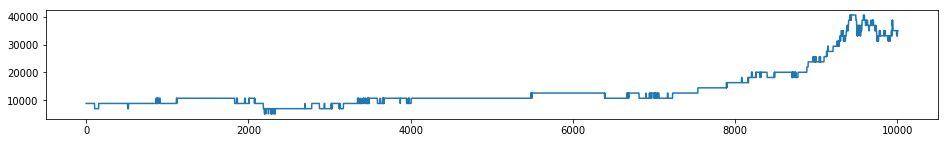

In [29]:
from tsaug import TimeWarp, Crop, Quantize, Drift, Reverse
from tsaug.visualization import plot

my_augmenter = (Quantize(n_levels=[20]))

#my_augmenter=TimeWarp()
X_aug1= my_augmenter.augment(data['close'].values)
plot(X_aug1)

In [30]:
quant=scaler.fit_transform(X_aug1.reshape(-1,1))

In [31]:
train_size = int(len(scaled) * 0.80)
val_size = int(len(scaled) * 0.10)

test_size = len(scaled) - train_size-val_size
train_q,val_q, test_q = quant[0:train_size,:],quant[train_size:train_size+val_size,:], quant[train_size+val_size:,:]
print(len(train_q),len(val_q), len(test_q))

8004 1000 1001


In [32]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    print(len(dataY))
    return np.array(dataX), np.array(dataY)

In [33]:
look_back = 12
trainX_q, trainY_q = create_dataset(train_q, look_back)
valX_q, valY_q = create_dataset(val_q, look_back)
testX_q, testY_q = create_dataset(test_q, look_back)

7992
988
989


In [34]:
look_back = 12
trainX_o, trainY_o = create_dataset(train, look_back)
valX_o, valY_o = create_dataset(val, look_back)
testX_o, testY_o = create_dataset(test, look_back)

7992
988
989


In [35]:
trainX_o = np.reshape(trainX_o, (trainX_o.shape[0], trainX_o.shape[1], 1))
valX_o = np.reshape(valX_o, (valX_o.shape[0], valX_o.shape[1],1))
testX_o = np.reshape(testX_o, (testX_o.shape[0],testX_o.shape[1], 1 ))

In [36]:
trainX_q = np.reshape(trainX_q, (trainX_q.shape[0], trainX_q.shape[1], 1))
valX_q = np.reshape(valX_q, (valX_q.shape[0], valX_q.shape[1],1))
testX_q = np.reshape(testX_q, (testX.shape[0],testX_q.shape[1], 1 ))

In [37]:
print(trainX.shape)
print(trainX_q.shape)

(7992, 12, 4)
(7992, 12, 1)


In [38]:
print(valX.shape)
print(valX_q.shape)

(988, 12, 4)
(988, 12, 1)


In [39]:
print(trainX_o.shape)
print(valX_o.shape)


(7992, 12, 1)
(988, 12, 1)


In [40]:
first_input = Input(shape=(12,1))
in1=layers.Conv1D(filters=64, kernel_size=5, activation='relu', input_shape=(6, 1))(first_input)
in2=layers.Conv1D(filters=64, kernel_size=1, activation='relu', input_shape=(6, 1))(in1)
#in3=layers.Conv1D(filters=128, kernel_size=1, activation='relu')(in2)
in4=layers.MaxPooling1D(pool_size=2)(in2)
in5=layers.Flatten()(in4)
in6=layers.Dense(100)(in5)
in6=layers.Dense(1)(in6)
#in6=layers.Bidirectional(LSTM(50))(first_input)

inputs = Input(shape=(12, 4), name='inputs')
#lstm_out = Bidirectional(LSTM(100, return_sequences=False))(inputs)
lstm_out = LSTM(50, return_sequences=False)(inputs)

#lstm_out = LSTM(64, return_sequences=True)(lstm_out)

    # Attention layer
#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([lstm_out, lstm_out])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([lstm_out, attn_out])
#flat_out = Flatten()(concat_out)

    # Dense layer
#dense_out = Dense(6, activation='relu')(flat_out)
concat=layers.Concatenate()([in6, lstm_out])
#dens=layers.Dense(100,activation='relu')(concat)
#dens=layers.Dense(100)
#dens= SeqSelfAttention(attention_activation='relu')(concat)

dens=layers.Dense(1)(concat)

model=tf.keras.Model(inputs=[first_input,inputs],outputs=[dens])
model.compile(optimizer='adam', loss='mse')


In [41]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 12, 1)]      0                                            
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 8, 64)        384         input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, 8, 64)        4160        conv1d_2[0][0]                   
__________________________________________________________________________________________________
max_pooling1d_1 (MaxPooling1D)  (None, 4, 64)        0           conv1d_3[0][0]                   
____________________________________________________________________________________________

In [42]:
checkpoint_path = "saved_weights/multi_btc_onestep_aug50.hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)

In [43]:
hist = model.fit([trainX_q,trainX],trainY, epochs = 200,validation_data=([valX_q,valX],valY), verbose = 1,callbacks=[cb])

Train on 7992 samples, validate on 988 samples
Epoch 1/200
7712/7992 [===========================>..] - ETA: 0s - loss: 5.7532e-04
Epoch 00001: val_loss improved from inf to 0.00013, saving model to saved_weights/multi_btc_onestep_aug50.hdf5
7992/7992 [==============================] - 4s 462us/sample - loss: 5.5605e-04 - val_loss: 1.3127e-04
Epoch 2/200
7712/7992 [===========================>..] - ETA: 0s - loss: 1.6132e-05
Epoch 00002: val_loss did not improve from 0.00013
7992/7992 [==============================] - 1s 171us/sample - loss: 1.5998e-05 - val_loss: 1.4067e-04
Epoch 3/200
7776/7992 [============================>.] - ETA: 0s - loss: 1.2493e-05
Epoch 00003: val_loss improved from 0.00013 to 0.00008, saving model to saved_weights/multi_btc_onestep_aug50.hdf5
7992/7992 [==============================] - 1s 172us/sample - loss: 1.2451e-05 - val_loss: 7.8899e-05
Epoch 4/200
7808/7992 [============================>.] - ETA: 0s - loss: 1.1632e-05
Epoch 00004: val_loss did not i

Epoch 32/200
7744/7992 [============================>.] - ETA: 0s - loss: 5.3386e-06
Epoch 00032: val_loss improved from 0.00002 to 0.00002, saving model to saved_weights/multi_btc_onestep_aug50.hdf5
7992/7992 [==============================] - 1s 172us/sample - loss: 5.3002e-06 - val_loss: 1.8780e-05
Epoch 33/200
7808/7992 [============================>.] - ETA: 0s - loss: 4.8923e-06
Epoch 00033: val_loss did not improve from 0.00002
7992/7992 [==============================] - 1s 170us/sample - loss: 4.9326e-06 - val_loss: 2.0980e-05
Epoch 34/200
7904/7992 [============================>.] - ETA: 0s - loss: 4.9336e-06
Epoch 00034: val_loss did not improve from 0.00002
7992/7992 [==============================] - 1s 161us/sample - loss: 4.9765e-06 - val_loss: 1.9377e-05
Epoch 35/200
7872/7992 [============================>.] - ETA: 0s - loss: 5.0038e-06
Epoch 00035: val_loss did not improve from 0.00002
7992/7992 [==============================] - 1s 168us/sample - loss: 5.0021e-06 - v

Epoch 64/200
7936/7992 [============================>.] - ETA: 0s - loss: 3.1774e-06
Epoch 00064: val_loss improved from 0.00001 to 0.00001, saving model to saved_weights/multi_btc_onestep_aug50.hdf5
7992/7992 [==============================] - 1s 171us/sample - loss: 3.1924e-06 - val_loss: 1.4295e-05
Epoch 65/200
7776/7992 [============================>.] - ETA: 0s - loss: 3.3971e-06
Epoch 00065: val_loss did not improve from 0.00001
7992/7992 [==============================] - 1s 169us/sample - loss: 3.3863e-06 - val_loss: 1.4354e-05
Epoch 66/200
7808/7992 [============================>.] - ETA: 0s - loss: 3.0729e-06
Epoch 00066: val_loss did not improve from 0.00001
7992/7992 [==============================] - 1s 169us/sample - loss: 3.0561e-06 - val_loss: 1.4383e-05
Epoch 67/200
7936/7992 [============================>.] - ETA: 0s - loss: 3.1596e-06
Epoch 00067: val_loss did not improve from 0.00001
7992/7992 [==============================] - 1s 161us/sample - loss: 3.1544e-06 - v

7808/7992 [============================>.] - ETA: 0s - loss: 3.0703e-06
Epoch 00098: val_loss did not improve from 0.00001
7992/7992 [==============================] - 1s 168us/sample - loss: 3.0502e-06 - val_loss: 1.6042e-05
Epoch 99/200
7904/7992 [============================>.] - ETA: 0s - loss: 3.2027e-06
Epoch 00099: val_loss did not improve from 0.00001
7992/7992 [==============================] - 1s 169us/sample - loss: 3.1879e-06 - val_loss: 1.5102e-05
Epoch 100/200
7808/7992 [============================>.] - ETA: 0s - loss: 3.1313e-06
Epoch 00100: val_loss did not improve from 0.00001
7992/7992 [==============================] - 1s 169us/sample - loss: 3.1340e-06 - val_loss: 1.7923e-05
Epoch 101/200
7904/7992 [============================>.] - ETA: 0s - loss: 3.2318e-06
Epoch 00101: val_loss did not improve from 0.00001
7992/7992 [==============================] - 1s 161us/sample - loss: 3.2147e-06 - val_loss: 1.4824e-05
Epoch 102/200
7968/7992 [============================>.

7904/7992 [============================>.] - ETA: 0s - loss: 3.2176e-06
Epoch 00166: val_loss did not improve from 0.00001
7992/7992 [==============================] - 1s 167us/sample - loss: 3.2059e-06 - val_loss: 1.4704e-05
Epoch 167/200
7904/7992 [============================>.] - ETA: 0s - loss: 3.1283e-06
Epoch 00167: val_loss did not improve from 0.00001
7992/7992 [==============================] - 1s 168us/sample - loss: 3.1291e-06 - val_loss: 1.5188e-05
Epoch 168/200
7808/7992 [============================>.] - ETA: 0s - loss: 3.0972e-06
Epoch 00168: val_loss did not improve from 0.00001
7992/7992 [==============================] - 1s 162us/sample - loss: 3.0728e-06 - val_loss: 1.5886e-05
Epoch 169/200
7936/7992 [============================>.] - ETA: 0s - loss: 3.1070e-06
Epoch 00169: val_loss did not improve from 0.00001
7992/7992 [==============================] - 1s 168us/sample - loss: 3.0993e-06 - val_loss: 1.4462e-05
Epoch 170/200
7744/7992 [============================>

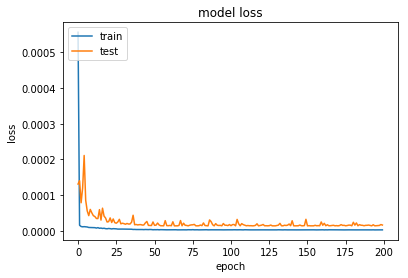

In [44]:
### aug history
# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

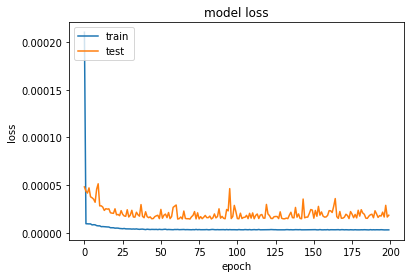

In [105]:
### non-aug history
# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

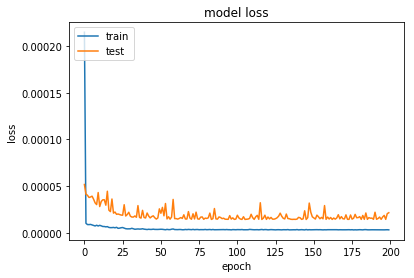

In [122]:
### aug history
# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [45]:
model.load_weights("saved_weights/multi_btc_onestep_aug50.hdf5")

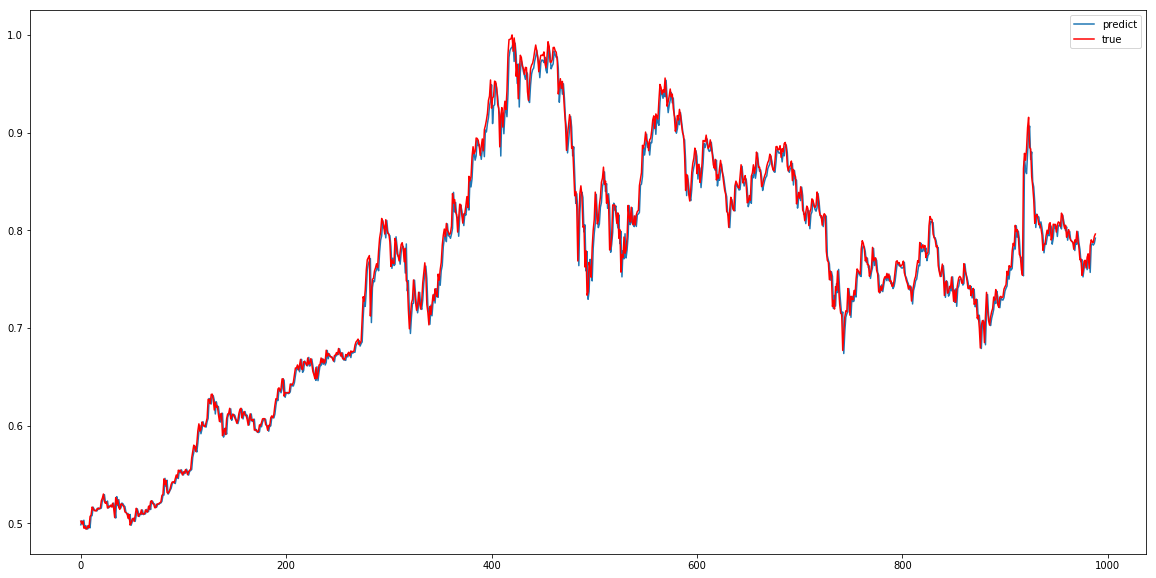

Test RMSE: 0.01224
Test MAE: 0.00859
Test MSE: 0.00015
Test RMSE: 465.17848
Test MAE: 326.58847


In [97]:
#origlnal

from sklearn.metrics import *
from matplotlib import pyplot
yhat = model.predict([testX_o,testX])
yhat=yhat.reshape(-1,1)

plt.figure(figsize=(20,10))

pyplot.plot(yhat, label='predict')
pyplot.plot(testY,'r', label='true')
pyplot.legend()
pyplot.show()

from math import *
rmse = sqrt(mean_squared_error(testY, yhat))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, yhat)
print('Test MAE: %.5f' % mae)

mse = mean_squared_error(testY, yhat)
print('Test MSE: %.5f' % mse)

yhat_inverse = yhat*(np.max(values)-np.min(values))+np.min(values)
testY_inverse=testY*(np.max(values)-np.min(values))+np.min(values)


rmse = sqrt(mean_squared_error(yhat_inverse, testY_inverse))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(yhat_inverse, testY_inverse)
print('Test MAE: %.5f' % mae)

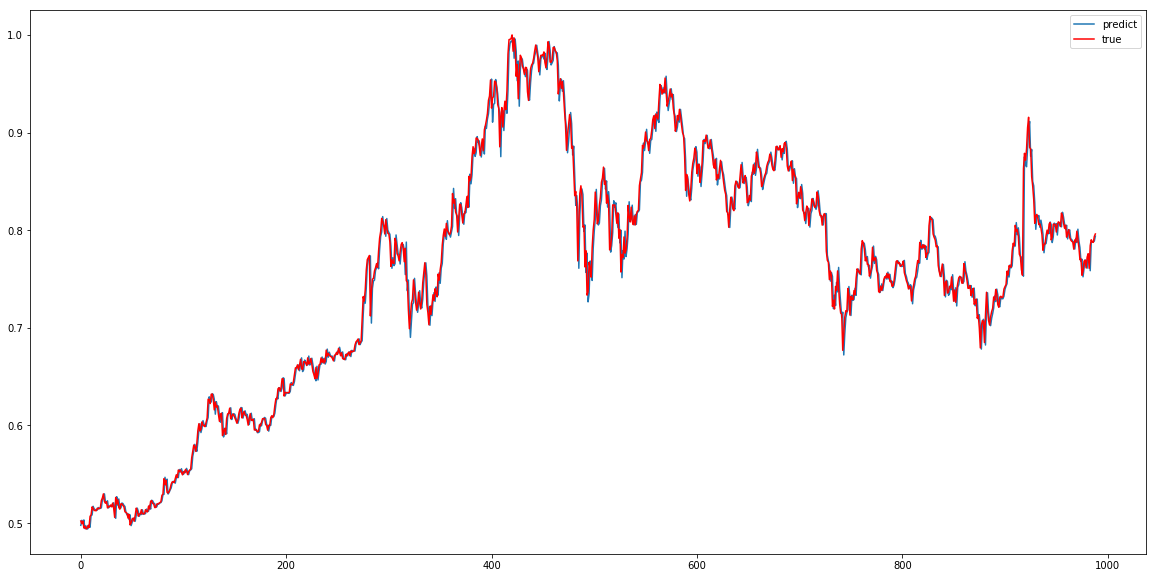

Test RMSE: 0.01207
Test MAE: 0.00842
Test MSE: 0.00015
Test RMSE: 459.03889
Test MAE: 320.04715


In [124]:
##quant 15 100
from sklearn.metrics import *
from matplotlib import pyplot
yhat = model.predict([testX_q,testX])
yhat=yhat.reshape(-1,1)

plt.figure(figsize=(20,10))

pyplot.plot(yhat, label='predict')
pyplot.plot(testY,'r', label='true')
pyplot.legend()
pyplot.show()

from math import *
rmse = sqrt(mean_squared_error(testY, yhat))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, yhat)
print('Test MAE: %.5f' % mae)

mse = mean_squared_error(testY, yhat)
print('Test MSE: %.5f' % mse)

yhat_inverse = yhat*(np.max(values)-np.min(values))+np.min(values)
testY_inverse=testY*(np.max(values)-np.min(values))+np.min(values)


rmse = sqrt(mean_squared_error(yhat_inverse, testY_inverse))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(yhat_inverse, testY_inverse)
print('Test MAE: %.5f' % mae)

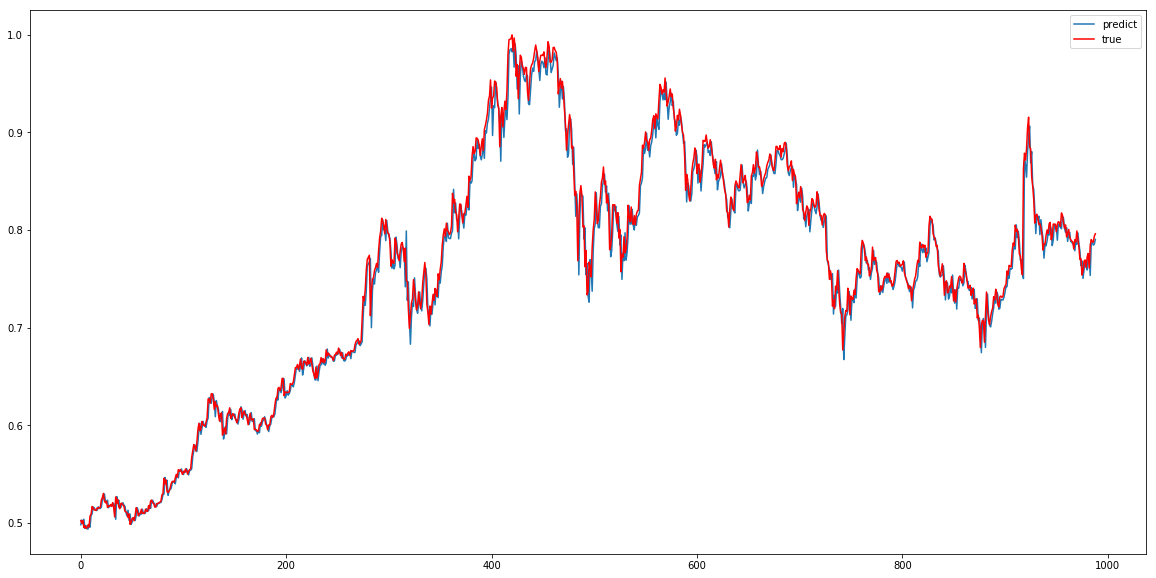

Test RMSE: 0.01300
Test MAE: 0.00911
Test MSE: 0.00017
Test RMSE: 494.20383
Test MAE: 346.31387


In [46]:
##quant 15 50
from sklearn.metrics import *
from matplotlib import pyplot
yhat = model.predict([testX_q,testX])
yhat=yhat.reshape(-1,1)

plt.figure(figsize=(20,10))

pyplot.plot(yhat, label='predict')
pyplot.plot(testY,'r', label='true')
pyplot.legend()
pyplot.show()

from math import *
rmse = sqrt(mean_squared_error(testY, yhat))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, yhat)
print('Test MAE: %.5f' % mae)

mse = mean_squared_error(testY, yhat)
print('Test MSE: %.5f' % mse)

yhat_inverse = yhat*(np.max(values)-np.min(values))+np.min(values)
testY_inverse=testY*(np.max(values)-np.min(values))+np.min(values)


rmse = sqrt(mean_squared_error(yhat_inverse, testY_inverse))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(yhat_inverse, testY_inverse)
print('Test MAE: %.5f' % mae)

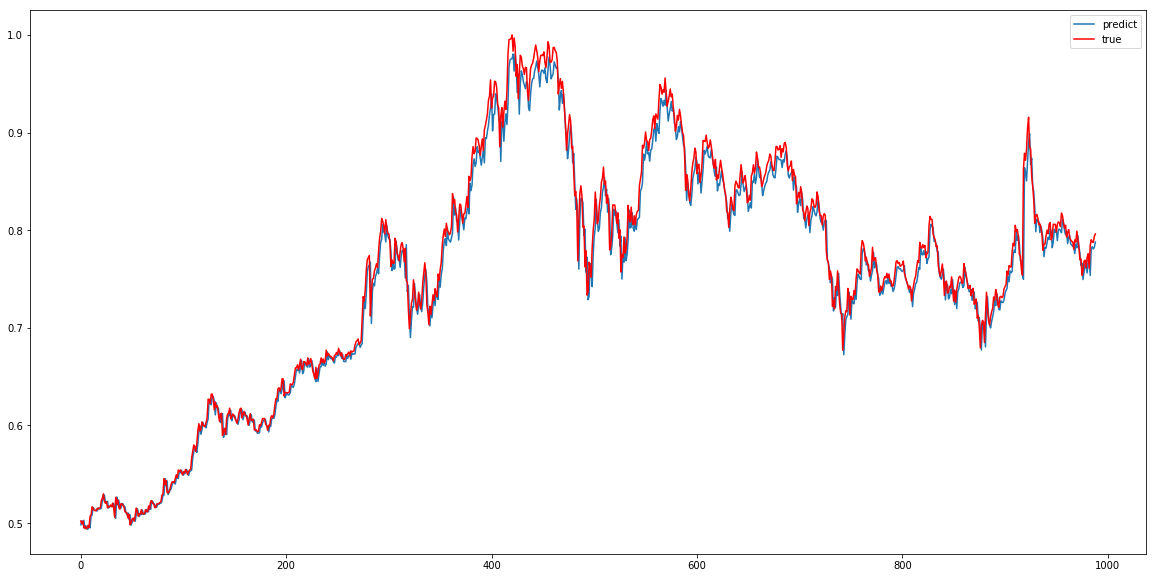

Test RMSE: 0.01393
Test MAE: 0.01014
Test MSE: 0.00019
Test RMSE: 529.71039
Test MAE: 385.34555


In [47]:
##50 고쳐라 이거 q에서 0으로
from sklearn.metrics import *
from matplotlib import pyplot
yhat = model.predict([testX_o,testX])
yhat=yhat.reshape(-1,1)

plt.figure(figsize=(20,10))

pyplot.plot(yhat, label='predict')
pyplot.plot(testY,'r', label='true')
pyplot.legend()
pyplot.show()

from math import *
rmse = sqrt(mean_squared_error(testY, yhat))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, yhat)
print('Test MAE: %.5f' % mae)

mse = mean_squared_error(testY, yhat)
print('Test MSE: %.5f' % mse)

yhat_inverse = yhat*(np.max(values)-np.min(values))+np.min(values)
testY_inverse=testY*(np.max(values)-np.min(values))+np.min(values)


rmse = sqrt(mean_squared_error(yhat_inverse, testY_inverse))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(yhat_inverse, testY_inverse)
print('Test MAE: %.5f' % mae)

### LSTM-CNN

In [10]:
from tensorflow.keras.models import Model

first_input = Input(shape=(12,4))

in1=LSTM(units =150 , return_sequences=True)(first_input)

#in1=TimeDistributed(Conv1D(filters=64, kernel_size=2, activation='relu'))(in1)
#in1= BatchNormalization(scale=False)(in1)
in1=Conv1D(filters=64, kernel_size=5, activation='relu')(in1)
#in1= BatchNormalization(scale=False)(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu')(in1)

#in1=add([in0,in1],name='extractor')
in1=MaxPooling1D(pool_size=2,name='extractor')(in1)

in1=Flatten()(in1)
#model.add(LSTM(units = 128, return_sequences=True))
#in1=LSTM(units =50 , return_sequences=False)(in1)
#lstm_out=Bidirectional(LSTM(units =100 , return_sequences=False))(lstm_out)

#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1, in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
#in1=MaxPooling1D(pool_size=2)(in1)

#flat_out = Flatten()(in1)
#flat_out=Dense(20, activation='relu')(flat_out)
#model.add(Dropout(drop_dense))
out1=Dense(1, activation = 'relu')(in1)
model=Model(inputs=first_input, outputs=out1)
model.compile(optimizer='adam', loss='mse')

checkpoint_path = "saved_weights/btc_lstmcnn.hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)


In [70]:
model.summary()

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 12, 4)]           0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 12, 150)           93000     
_________________________________________________________________
conv1d_24 (Conv1D)           (None, 8, 64)             48064     
_________________________________________________________________
conv1d_25 (Conv1D)           (None, 8, 64)             4160      
_________________________________________________________________
extractor (MaxPooling1D)     (None, 4, 64)             0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 256)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 257

In [54]:
checkpoint_path = "saved_weights/btc_lstmcnn2.hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)

In [55]:
history=model.fit(trainX, trainY, epochs=500, batch_size=100, validation_data=(valX, valY), verbose=1, callbacks=[cb])

Train on 7992 samples, validate on 988 samples
Epoch 1/500
7600/7992 [===========================>..] - ETA: 0s - loss: 6.4968e-04
Epoch 00001: val_loss improved from inf to 0.00009, saving model to saved_weights/btc_lstmcnn2.hdf5
7992/7992 [==============================] - 2s 278us/sample - loss: 6.1876e-04 - val_loss: 9.1262e-05
Epoch 2/500
7600/7992 [===========================>..] - ETA: 0s - loss: 1.6501e-05
Epoch 00002: val_loss improved from 0.00009 to 0.00008, saving model to saved_weights/btc_lstmcnn2.hdf5
7992/7992 [==============================] - 1s 127us/sample - loss: 1.6753e-05 - val_loss: 8.4698e-05
Epoch 3/500
7600/7992 [===========================>..] - ETA: 0s - loss: 1.6356e-05
Epoch 00003: val_loss improved from 0.00008 to 0.00008, saving model to saved_weights/btc_lstmcnn2.hdf5
7992/7992 [==============================] - 1s 126us/sample - loss: 1.6455e-05 - val_loss: 8.4572e-05
Epoch 4/500
7600/7992 [===========================>..] - ETA: 0s - loss: 1.6691e-05


Epoch 32/500
7900/7992 [============================>.] - ETA: 0s - loss: 7.6076e-06
Epoch 00032: val_loss improved from 0.00004 to 0.00004, saving model to saved_weights/btc_lstmcnn2.hdf5
7992/7992 [==============================] - 1s 138us/sample - loss: 7.6142e-06 - val_loss: 3.8719e-05
Epoch 33/500
7600/7992 [===========================>..] - ETA: 0s - loss: 7.2327e-06
Epoch 00033: val_loss did not improve from 0.00004
7992/7992 [==============================] - 1s 124us/sample - loss: 7.3995e-06 - val_loss: 6.2829e-05
Epoch 34/500
7600/7992 [===========================>..] - ETA: 0s - loss: 6.4627e-06
Epoch 00034: val_loss did not improve from 0.00004
7992/7992 [==============================] - 1s 125us/sample - loss: 6.5698e-06 - val_loss: 4.5380e-05
Epoch 35/500
7600/7992 [===========================>..] - ETA: 0s - loss: 6.5653e-06
Epoch 00035: val_loss did not improve from 0.00004
7992/7992 [==============================] - 1s 125us/sample - loss: 6.5894e-06 - val_loss: 3.

Epoch 98/500
7600/7992 [===========================>..] - ETA: 0s - loss: 4.4559e-06
Epoch 00098: val_loss did not improve from 0.00002
7992/7992 [==============================] - 1s 125us/sample - loss: 4.4095e-06 - val_loss: 4.6394e-05
Epoch 99/500
7600/7992 [===========================>..] - ETA: 0s - loss: 4.7613e-06
Epoch 00099: val_loss did not improve from 0.00002
7992/7992 [==============================] - 1s 125us/sample - loss: 4.6966e-06 - val_loss: 2.7451e-05
Epoch 100/500
7600/7992 [===========================>..] - ETA: 0s - loss: 4.2384e-06
Epoch 00100: val_loss did not improve from 0.00002
7992/7992 [==============================] - 1s 124us/sample - loss: 4.1936e-06 - val_loss: 2.7698e-05
Epoch 101/500
7600/7992 [===========================>..] - ETA: 0s - loss: 6.4765e-06
Epoch 00101: val_loss did not improve from 0.00002
7992/7992 [==============================] - 1s 126us/sample - loss: 6.2957e-06 - val_loss: 2.8959e-05
Epoch 102/500
7600/7992 [=================

Epoch 132/500
7600/7992 [===========================>..] - ETA: 0s - loss: 4.9319e-06
Epoch 00132: val_loss did not improve from 0.00002
7992/7992 [==============================] - 1s 125us/sample - loss: 4.8221e-06 - val_loss: 3.2545e-05
Epoch 133/500
7600/7992 [===========================>..] - ETA: 0s - loss: 3.6557e-06
Epoch 00133: val_loss did not improve from 0.00002
7992/7992 [==============================] - 1s 123us/sample - loss: 3.6650e-06 - val_loss: 2.0186e-05
Epoch 134/500
7600/7992 [===========================>..] - ETA: 0s - loss: 3.9044e-06
Epoch 00134: val_loss did not improve from 0.00002
7992/7992 [==============================] - 1s 124us/sample - loss: 3.9386e-06 - val_loss: 1.8374e-05
Epoch 135/500
7600/7992 [===========================>..] - ETA: 0s - loss: 3.8121e-06
Epoch 00135: val_loss did not improve from 0.00002
7992/7992 [==============================] - 1s 125us/sample - loss: 3.8198e-06 - val_loss: 3.4800e-05
Epoch 136/500
7600/7992 [===============

Epoch 166/500
7600/7992 [===========================>..] - ETA: 0s - loss: 4.4680e-06
Epoch 00166: val_loss did not improve from 0.00002
7992/7992 [==============================] - 1s 124us/sample - loss: 4.4296e-06 - val_loss: 1.8446e-05
Epoch 167/500
7600/7992 [===========================>..] - ETA: 0s - loss: 3.7595e-06
Epoch 00167: val_loss did not improve from 0.00002
7992/7992 [==============================] - 1s 124us/sample - loss: 3.7796e-06 - val_loss: 3.1930e-05
Epoch 168/500
7600/7992 [===========================>..] - ETA: 0s - loss: 3.3758e-06
Epoch 00168: val_loss did not improve from 0.00002
7992/7992 [==============================] - 1s 122us/sample - loss: 3.3652e-06 - val_loss: 3.0688e-05
Epoch 169/500
7600/7992 [===========================>..] - ETA: 0s - loss: 3.3853e-06
Epoch 00169: val_loss did not improve from 0.00002
7992/7992 [==============================] - 1s 125us/sample - loss: 3.3677e-06 - val_loss: 1.7610e-05
Epoch 170/500
7600/7992 [===============

7600/7992 [===========================>..] - ETA: 0s - loss: 3.7172e-06
Epoch 00234: val_loss did not improve from 0.00002
7992/7992 [==============================] - 1s 124us/sample - loss: 3.6814e-06 - val_loss: 1.8005e-05
Epoch 235/500
7600/7992 [===========================>..] - ETA: 0s - loss: 3.0553e-06
Epoch 00235: val_loss did not improve from 0.00002
7992/7992 [==============================] - 1s 125us/sample - loss: 3.0656e-06 - val_loss: 2.0369e-05
Epoch 236/500
7600/7992 [===========================>..] - ETA: 0s - loss: 3.4062e-06
Epoch 00236: val_loss did not improve from 0.00002
7992/7992 [==============================] - 1s 126us/sample - loss: 3.3730e-06 - val_loss: 2.2457e-05
Epoch 237/500
7600/7992 [===========================>..] - ETA: 0s - loss: 3.3264e-06
Epoch 00237: val_loss improved from 0.00002 to 0.00002, saving model to saved_weights/btc_lstmcnn2.hdf5
7992/7992 [==============================] - 1s 127us/sample - loss: 3.2844e-06 - val_loss: 1.7331e-05
E

Epoch 268/500
7600/7992 [===========================>..] - ETA: 0s - loss: 3.1652e-06
Epoch 00268: val_loss improved from 0.00002 to 0.00002, saving model to saved_weights/btc_lstmcnn2.hdf5
7992/7992 [==============================] - 1s 125us/sample - loss: 3.2161e-06 - val_loss: 1.7122e-05
Epoch 269/500
7600/7992 [===========================>..] - ETA: 0s - loss: 3.2722e-06
Epoch 00269: val_loss did not improve from 0.00002
7992/7992 [==============================] - 1s 124us/sample - loss: 3.2479e-06 - val_loss: 3.9542e-05
Epoch 270/500
7600/7992 [===========================>..] - ETA: 0s - loss: 3.1237e-06
Epoch 00270: val_loss did not improve from 0.00002
7992/7992 [==============================] - 1s 124us/sample - loss: 3.1248e-06 - val_loss: 4.5992e-05
Epoch 271/500
7600/7992 [===========================>..] - ETA: 0s - loss: 3.3113e-06
Epoch 00271: val_loss did not improve from 0.00002
7992/7992 [==============================] - 1s 123us/sample - loss: 3.2544e-06 - val_loss

7600/7992 [===========================>..] - ETA: 0s - loss: 3.5531e-06
Epoch 00335: val_loss did not improve from 0.00002
7992/7992 [==============================] - 1s 125us/sample - loss: 3.5626e-06 - val_loss: 1.9380e-05
Epoch 336/500
7600/7992 [===========================>..] - ETA: 0s - loss: 3.4708e-06
Epoch 00336: val_loss did not improve from 0.00002
7992/7992 [==============================] - 1s 125us/sample - loss: 3.4504e-06 - val_loss: 2.3571e-05
Epoch 337/500
7600/7992 [===========================>..] - ETA: 0s - loss: 3.6598e-06
Epoch 00337: val_loss did not improve from 0.00002
7992/7992 [==============================] - 1s 124us/sample - loss: 3.6173e-06 - val_loss: 2.2732e-05
Epoch 338/500
7600/7992 [===========================>..] - ETA: 0s - loss: 3.6238e-06
Epoch 00338: val_loss improved from 0.00002 to 0.00002, saving model to saved_weights/btc_lstmcnn2.hdf5
7992/7992 [==============================] - 1s 127us/sample - loss: 3.5474e-06 - val_loss: 1.5728e-05
E

Epoch 369/500
7600/7992 [===========================>..] - ETA: 0s - loss: 3.2054e-06
Epoch 00369: val_loss did not improve from 0.00002
7992/7992 [==============================] - 1s 126us/sample - loss: 3.3165e-06 - val_loss: 2.2076e-05
Epoch 370/500
7600/7992 [===========================>..] - ETA: 0s - loss: 3.0035e-06
Epoch 00370: val_loss did not improve from 0.00002
7992/7992 [==============================] - 1s 125us/sample - loss: 2.9930e-06 - val_loss: 1.9761e-05
Epoch 371/500
7600/7992 [===========================>..] - ETA: 0s - loss: 3.1505e-06
Epoch 00371: val_loss did not improve from 0.00002
7992/7992 [==============================] - 1s 125us/sample - loss: 3.2023e-06 - val_loss: 1.5851e-05
Epoch 372/500
7600/7992 [===========================>..] - ETA: 0s - loss: 3.1238e-06
Epoch 00372: val_loss did not improve from 0.00002
7992/7992 [==============================] - 1s 125us/sample - loss: 3.1018e-06 - val_loss: 1.6636e-05
Epoch 373/500
7600/7992 [===============

Epoch 403/500
7600/7992 [===========================>..] - ETA: 0s - loss: 3.3720e-06
Epoch 00403: val_loss did not improve from 0.00001
7992/7992 [==============================] - 1s 124us/sample - loss: 3.3942e-06 - val_loss: 2.4347e-05
Epoch 404/500
7600/7992 [===========================>..] - ETA: 0s - loss: 3.0266e-06
Epoch 00404: val_loss did not improve from 0.00001
7992/7992 [==============================] - 1s 126us/sample - loss: 2.9980e-06 - val_loss: 3.4393e-05
Epoch 405/500
7600/7992 [===========================>..] - ETA: 0s - loss: 3.6470e-06
Epoch 00405: val_loss did not improve from 0.00001
7992/7992 [==============================] - 1s 126us/sample - loss: 3.7538e-06 - val_loss: 4.0663e-05
Epoch 406/500
7600/7992 [===========================>..] - ETA: 0s - loss: 3.0414e-06
Epoch 00406: val_loss did not improve from 0.00001
7992/7992 [==============================] - 1s 125us/sample - loss: 3.0529e-06 - val_loss: 2.2616e-05
Epoch 407/500
7600/7992 [===============

Epoch 437/500
7600/7992 [===========================>..] - ETA: 0s - loss: 3.0013e-06
Epoch 00437: val_loss did not improve from 0.00001
7992/7992 [==============================] - 1s 124us/sample - loss: 3.0306e-06 - val_loss: 1.5016e-05
Epoch 438/500
7600/7992 [===========================>..] - ETA: 0s - loss: 3.1037e-06
Epoch 00438: val_loss improved from 0.00001 to 0.00001, saving model to saved_weights/btc_lstmcnn2.hdf5
7992/7992 [==============================] - 1s 128us/sample - loss: 3.0649e-06 - val_loss: 1.4056e-05
Epoch 439/500
7600/7992 [===========================>..] - ETA: 0s - loss: 2.8961e-06
Epoch 00439: val_loss did not improve from 0.00001
7992/7992 [==============================] - 1s 123us/sample - loss: 2.9972e-06 - val_loss: 1.5223e-05
Epoch 440/500
7600/7992 [===========================>..] - ETA: 0s - loss: 3.0973e-06
Epoch 00440: val_loss did not improve from 0.00001
7992/7992 [==============================] - 1s 125us/sample - loss: 3.0456e-06 - val_loss

Epoch 471/500
7600/7992 [===========================>..] - ETA: 0s - loss: 3.1202e-06
Epoch 00471: val_loss did not improve from 0.00001
7992/7992 [==============================] - 1s 123us/sample - loss: 3.2797e-06 - val_loss: 1.7644e-05
Epoch 472/500
7600/7992 [===========================>..] - ETA: 0s - loss: 3.4310e-06
Epoch 00472: val_loss did not improve from 0.00001
7992/7992 [==============================] - 1s 122us/sample - loss: 3.3521e-06 - val_loss: 2.0613e-05
Epoch 473/500
7600/7992 [===========================>..] - ETA: 0s - loss: 3.0622e-06
Epoch 00473: val_loss did not improve from 0.00001
7992/7992 [==============================] - 1s 125us/sample - loss: 3.0033e-06 - val_loss: 1.7100e-05
Epoch 474/500
7600/7992 [===========================>..] - ETA: 0s - loss: 3.7187e-06
Epoch 00474: val_loss did not improve from 0.00001
7992/7992 [==============================] - 1s 126us/sample - loss: 3.6569e-06 - val_loss: 1.6454e-05
Epoch 475/500
7600/7992 [===============

In [11]:
model.load_weights("saved_weights/btc_lstmcnn2.hdf5")

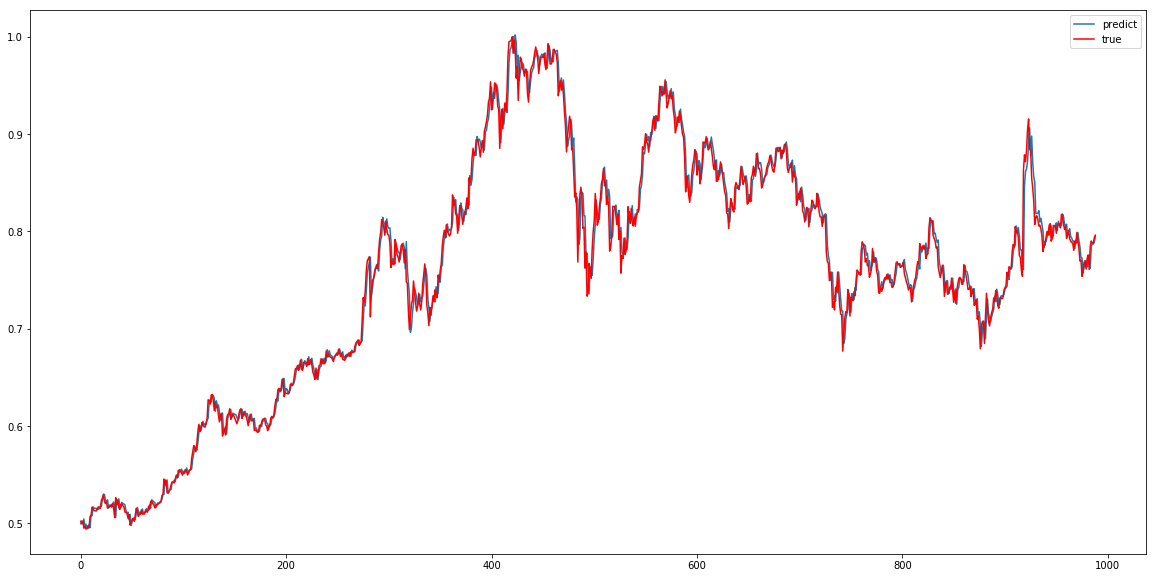

Test RMSE: 0.01254
Test MAE: 0.00860
Test MSE: 0.00016
Test RMSE: 476.80912
Test MAE: 327.09726


In [57]:
### lstm(150)-1dcnn(5,1), saved_weights/btc_lstmcnn2.hdf5, one-step

from sklearn.metrics import *
from matplotlib import pyplot
yhat = model.predict([testX])
yhat=yhat.reshape(-1,1)

plt.figure(figsize=(20,10))

pyplot.plot(yhat, label='predict')
pyplot.plot(testY,'r', label='true')
pyplot.legend()
pyplot.show()

from math import *
rmse = sqrt(mean_squared_error(testY, yhat))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, yhat)
print('Test MAE: %.5f' % mae)

mse = mean_squared_error(testY, yhat)
print('Test MSE: %.5f' % mse)

yhat_inverse = yhat*(np.max(values)-np.min(values))+np.min(values)
testY_inverse=testY*(np.max(values)-np.min(values))+np.min(values)


rmse = sqrt(mean_squared_error(yhat_inverse, testY_inverse))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(yhat_inverse, testY_inverse)
print('Test MAE: %.5f' % mae)

(1, 12, 4)


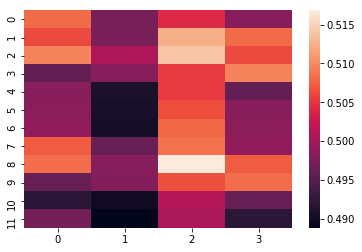

lstm/kernel:0 (4, 600)
[[-0.00523385 -0.12137199  0.05027313 ...  0.07419784  0.13033234
  -0.00559339]
 [ 0.00279347 -0.08366162 -0.05618417 ...  0.00567128  0.04226498
  -0.09434788]
 [ 0.03999047 -0.10214391  0.01123428 ...  0.13496259  0.06200957
   0.00648963]
 [ 0.07318545 -0.00716773  0.04891165 ... -0.00489349  0.04570969
   0.00301406]]
lstm/recurrent_kernel:0 (150, 600)
[[-0.00728719 -0.02010527  0.01942466 ... -0.01851926 -0.02140465
  -0.01366649]
 [ 0.02224542 -0.02014048  0.01284998 ...  0.02935693 -0.00813557
  -0.03158536]
 [ 0.001823    0.03377017  0.00640959 ... -0.00764107  0.01659416
  -0.00678148]
 ...
 [-0.00792657 -0.0268858  -0.01958958 ...  0.0427576   0.00156951
  -0.02827969]
 [-0.04133375 -0.02566076  0.04435173 ... -0.00747915 -0.02675423
  -0.05468845]
 [ 0.03796083  0.02899362 -0.02324221 ...  0.00904815  0.01653093
   0.02106491]]
lstm/bias:0 (600,)
[-0.06726478 -0.09554813  0.03014908 -0.04868734 -0.04294541 -0.07453881
  0.10897589 -0.08510567 -0.03669

In [13]:
from tensorflow.keras.models import Model

chars = '0123456789+ '
ctable = CharacterTable(chars)
i = 0
output_final = model.predict(np.array([testX[i]]))

#print(ctable.decode(valX[i]),
 #     ctable.decode(valY[i]),
  #    ctable.decode(output_final[0]))

intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.layers[0].output)
output = intermediate_layer_model.predict(np.array([testX[i]]))
print(output.shape)

import matplotlib.pyplot as plt
import seaborn as sns

plt.clf()
# h = np.reshape(output[0], (-1, 8))
# sns.heatmap(h)
sns.heatmap(output[0])
plt.show()

# %% Print weights.
names = [weight.name for layer in model.layers for weight in layer.weights]
weights = model.get_weights()

# suppress scientific notation
np.set_printoptions(suppress=True)
for name, weight in zip(names, weights):
    print(name, weight.shape)
    print(weight)

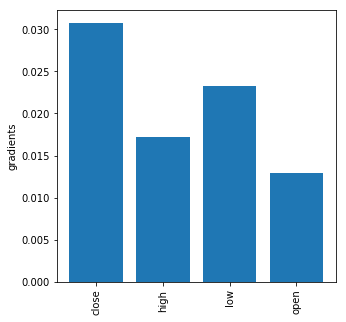

In [16]:
columns='close','high','low','open'

grad_imp = gradient_importance(X_test[id_], model)

plt.figure(figsize=(5,5))
plt.bar(range(len(grad_imp)), grad_imp)
plt.xticks(range(len(columns)), columns, rotation=90)
plt.ylabel('gradients'); #plt.title(pd.to_datetime(test_date[sequence_length+id_]))
np.set_printoptions(False)

### 1D-CNN

In [44]:

first_input = Input(shape=(12,4))

in1=Conv1D(filters=64, kernel_size=5, activation='relu',padding='same')(first_input)
#in1= BatchNormalization(scale=False)(in1)

#in0=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in0)
#in1=Conv1D(filters=64, kernel_size=3, activation='relu',padding='same')(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu',padding='same')(in1)
#in1= BatchNormalization(scale=False)(in1)

#in1=add([in0,in1],name='extractor')
#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1,in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
in1=MaxPooling1D(pool_size=2)(in1)
in1=Flatten()(in1)
#in1=Dense(100, activation='relu')(in1)
out=Dense(1)(in1)
model=tf.keras.Model(inputs=[first_input],outputs=[out])
model.compile(optimizer='adam', loss='mse')

model.summary()

checkpoint_path = "saved_weights/btc_1dcnn1.hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)
# fit model

# fit model9
#history=model.fit(trainX, trainY, epochs=200, batch_size=100, validation_data=(valX, valY), verbose=1, callbacks=[cb])

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 12, 4)]           0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 12, 64)            1344      
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 12, 64)            4160      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 6, 64)             0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 384)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 385       
Total params: 5,889
Trainable params: 5,889
Non-trainable params: 0
_________________________________________________________

In [45]:
history=model.fit(trainX, trainY, epochs=300, batch_size=100, validation_data=(valX, valY), verbose=1, callbacks=[cb])

Train on 7992 samples, validate on 988 samples
Epoch 1/300
6700/7992 [========================>.....] - ETA: 0s - loss: 8.5391e-04
Epoch 00001: val_loss improved from inf to 0.00011, saving model to saved_weights/btc_1dcnn1.hdf5
7992/7992 [==============================] - 1s 63us/sample - loss: 7.1789e-04 - val_loss: 1.1427e-04
Epoch 2/300
7100/7992 [=========================>....] - ETA: 0s - loss: 1.2055e-05
Epoch 00002: val_loss improved from 0.00011 to 0.00010, saving model to saved_weights/btc_1dcnn1.hdf5
7992/7992 [==============================] - 0s 48us/sample - loss: 1.2253e-05 - val_loss: 9.5069e-05
Epoch 3/300
7100/7992 [=========================>....] - ETA: 0s - loss: 1.1857e-05
Epoch 00003: val_loss improved from 0.00010 to 0.00008, saving model to saved_weights/btc_1dcnn1.hdf5
7992/7992 [==============================] - 0s 35us/sample - loss: 1.1660e-05 - val_loss: 8.3564e-05
Epoch 4/300
7500/7992 [===========================>..] - ETA: 0s - loss: 1.0897e-05
Epoch 000

Epoch 34/300
7300/7992 [==========================>...] - ETA: 0s - loss: 4.0962e-06
Epoch 00034: val_loss did not improve from 0.00004
7992/7992 [==============================] - 1s 63us/sample - loss: 4.1021e-06 - val_loss: 1.1086e-04
Epoch 35/300
7300/7992 [==========================>...] - ETA: 0s - loss: 4.4628e-06
Epoch 00035: val_loss did not improve from 0.00004
7992/7992 [==============================] - 1s 63us/sample - loss: 4.3828e-06 - val_loss: 9.3554e-05
Epoch 36/300
7300/7992 [==========================>...] - ETA: 0s - loss: 3.9895e-06
Epoch 00036: val_loss did not improve from 0.00004
7992/7992 [==============================] - 1s 63us/sample - loss: 3.9766e-06 - val_loss: 6.8022e-05
Epoch 37/300
7300/7992 [==========================>...] - ETA: 0s - loss: 4.0498e-06
Epoch 00037: val_loss did not improve from 0.00004
7992/7992 [==============================] - 1s 63us/sample - loss: 4.0916e-06 - val_loss: 5.1742e-05
Epoch 38/300
7300/7992 [========================

Epoch 69/300
7800/7992 [============================>.] - ETA: 0s - loss: 3.6688e-06
Epoch 00069: val_loss did not improve from 0.00004
7992/7992 [==============================] - 0s 52us/sample - loss: 3.6257e-06 - val_loss: 6.8958e-05
Epoch 70/300
7800/7992 [============================>.] - ETA: 0s - loss: 3.5585e-06
Epoch 00070: val_loss did not improve from 0.00004
7992/7992 [==============================] - 0s 52us/sample - loss: 3.6044e-06 - val_loss: 8.4184e-05
Epoch 71/300
7800/7992 [============================>.] - ETA: 0s - loss: 3.4394e-06
Epoch 00071: val_loss did not improve from 0.00004
7992/7992 [==============================] - 0s 52us/sample - loss: 3.4254e-06 - val_loss: 1.2027e-04
Epoch 72/300
7800/7992 [============================>.] - ETA: 0s - loss: 3.8391e-06
Epoch 00072: val_loss did not improve from 0.00004
7992/7992 [==============================] - 0s 53us/sample - loss: 3.8062e-06 - val_loss: 7.4257e-05
Epoch 73/300
7300/7992 [========================

Epoch 103/300
7300/7992 [==========================>...] - ETA: 0s - loss: 3.6095e-06
Epoch 00103: val_loss did not improve from 0.00003
7992/7992 [==============================] - 0s 49us/sample - loss: 3.5360e-06 - val_loss: 5.8649e-05
Epoch 104/300
7300/7992 [==========================>...] - ETA: 0s - loss: 3.1433e-06
Epoch 00104: val_loss did not improve from 0.00003
7992/7992 [==============================] - 0s 49us/sample - loss: 3.1385e-06 - val_loss: 5.3001e-05
Epoch 105/300
7300/7992 [==========================>...] - ETA: 0s - loss: 3.1570e-06
Epoch 00105: val_loss did not improve from 0.00003
7992/7992 [==============================] - 0s 49us/sample - loss: 3.1156e-06 - val_loss: 4.1519e-05
Epoch 106/300
7300/7992 [==========================>...] - ETA: 0s - loss: 3.5525e-06
Epoch 00106: val_loss did not improve from 0.00003
7992/7992 [==============================] - 0s 49us/sample - loss: 3.4771e-06 - val_loss: 5.3750e-05
Epoch 107/300
7300/7992 [===================

Epoch 137/300
7300/7992 [==========================>...] - ETA: 0s - loss: 3.0643e-06
Epoch 00137: val_loss did not improve from 0.00002
7992/7992 [==============================] - 1s 63us/sample - loss: 3.0625e-06 - val_loss: 2.2807e-05
Epoch 138/300
7300/7992 [==========================>...] - ETA: 0s - loss: 3.0793e-06
Epoch 00138: val_loss did not improve from 0.00002
7992/7992 [==============================] - 1s 63us/sample - loss: 3.0313e-06 - val_loss: 2.5875e-05
Epoch 139/300
7300/7992 [==========================>...] - ETA: 0s - loss: 3.5500e-06
Epoch 00139: val_loss did not improve from 0.00002
7992/7992 [==============================] - 1s 63us/sample - loss: 3.4964e-06 - val_loss: 3.4491e-05
Epoch 140/300
7300/7992 [==========================>...] - ETA: 0s - loss: 3.2230e-06
Epoch 00140: val_loss did not improve from 0.00002
7992/7992 [==============================] - 1s 63us/sample - loss: 3.1797e-06 - val_loss: 3.7469e-05
Epoch 141/300
7300/7992 [===================

Epoch 205/300
7600/7992 [===========================>..] - ETA: 0s - loss: 3.0470e-06
Epoch 00205: val_loss did not improve from 0.00002
7992/7992 [==============================] - 0s 54us/sample - loss: 3.0116e-06 - val_loss: 2.2554e-05
Epoch 206/300
6000/7992 [=====================>........] - ETA: 0s - loss: 3.1465e-06
Epoch 00206: val_loss did not improve from 0.00002
7992/7992 [==============================] - 0s 28us/sample - loss: 3.1196e-06 - val_loss: 2.6992e-05
Epoch 207/300
7500/7992 [===========================>..] - ETA: 0s - loss: 2.9668e-06
Epoch 00207: val_loss did not improve from 0.00002
7992/7992 [==============================] - 0s 32us/sample - loss: 3.0514e-06 - val_loss: 2.8347e-05
Epoch 208/300
7900/7992 [============================>.] - ETA: 0s - loss: 2.9209e-06
Epoch 00208: val_loss did not improve from 0.00002
7992/7992 [==============================] - 0s 45us/sample - loss: 2.9223e-06 - val_loss: 3.7643e-05
Epoch 209/300
7300/7992 [===================

Epoch 239/300
7800/7992 [============================>.] - ETA: 0s - loss: 2.9614e-06
Epoch 00239: val_loss did not improve from 0.00001
7992/7992 [==============================] - 0s 51us/sample - loss: 3.0542e-06 - val_loss: 2.7594e-05
Epoch 240/300
7800/7992 [============================>.] - ETA: 0s - loss: 3.5531e-06
Epoch 00240: val_loss did not improve from 0.00001
7992/7992 [==============================] - 0s 51us/sample - loss: 3.5261e-06 - val_loss: 4.6807e-05
Epoch 241/300
7800/7992 [============================>.] - ETA: 0s - loss: 3.1290e-06
Epoch 00241: val_loss did not improve from 0.00001
7992/7992 [==============================] - 0s 51us/sample - loss: 3.1091e-06 - val_loss: 1.5692e-05
Epoch 242/300
7800/7992 [============================>.] - ETA: 0s - loss: 2.8326e-06
Epoch 00242: val_loss did not improve from 0.00001
7992/7992 [==============================] - 0s 51us/sample - loss: 2.9250e-06 - val_loss: 1.5208e-05
Epoch 243/300
7800/7992 [===================

In [46]:
model.load_weights("saved_weights/btc_1dcnn1.hdf5")

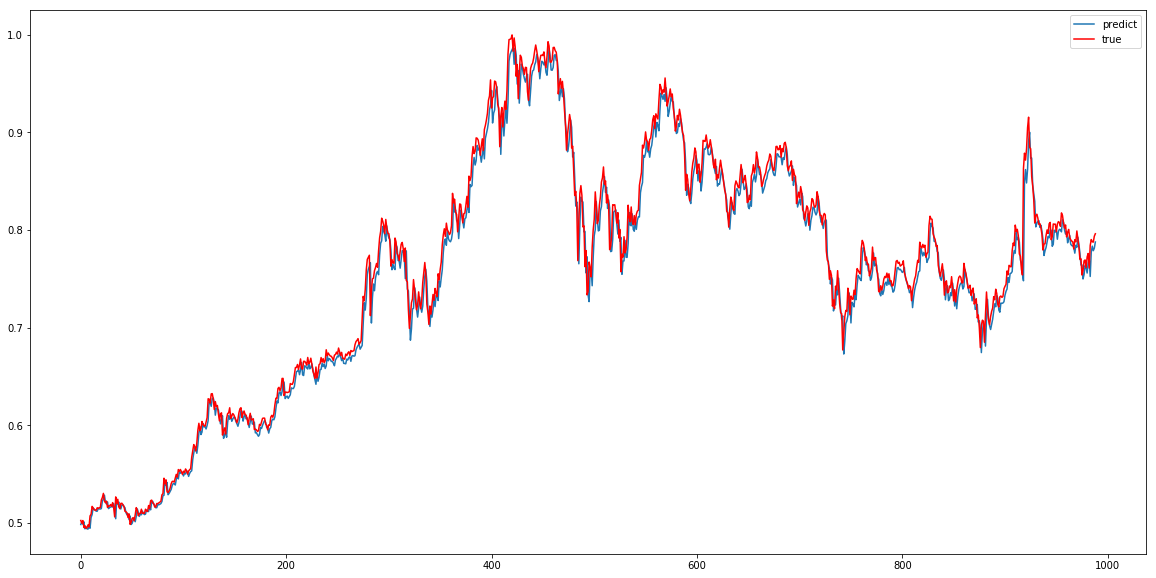

Test RMSE: 0.01369
Test MAE: 0.01001
Test MSE: 0.00019
Test RMSE: 520.42483
Test MAE: 380.52362


In [47]:
from sklearn.metrics import *
from matplotlib import pyplot
yhat = model.predict([testX])
yhat=yhat.reshape(-1,1)

plt.figure(figsize=(20,10))

pyplot.plot(yhat, label='predict')
pyplot.plot(testY,'r', label='true')
pyplot.legend()
pyplot.show()

from math import *
rmse = sqrt(mean_squared_error(testY, yhat))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, yhat)
print('Test MAE: %.5f' % mae)

mse = mean_squared_error(testY, yhat)
print('Test MSE: %.5f' % mse)

yhat_inverse = yhat*(np.max(values)-np.min(values))+np.min(values)
testY_inverse=testY*(np.max(values)-np.min(values))+np.min(values)


rmse = sqrt(mean_squared_error(yhat_inverse, testY_inverse))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(yhat_inverse, testY_inverse)
print('Test MAE: %.5f' % mae)

### CNN-LSTM

In [82]:
from tensorflow.keras.models import Model

first_input = Input(shape=(12,4))

#in1=LSTM(units =150 , return_sequences=True)(first_input)

#in1=TimeDistributed(Conv1D(filters=64, kernel_size=2, activation='relu'))(in1)
#in1= BatchNormalization(scale=False)(in1)
in1=Conv1D(filters=64, kernel_size=5, activation='relu')(first_input)
#in1= BatchNormalization(scale=False)(in0)

in1=Conv1D(filters=64, kernel_size=1, activation='relu')(in1)

#in1=add([in0,in1],name='extractor')
in1=MaxPooling1D(pool_size=2,name='extractor')(in1)

#in1=Flatten()(in1)
#model.add(LSTM(units = 128, return_sequences=True))
in1=LSTM(units =150 , return_sequences=False)(in1)
#lstm_out=Bidirectional(LSTM(units =100 , return_sequences=False))(lstm_out)

#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1, in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
#in1=MaxPooling1D(pool_size=2)(in1)

#flat_out = Flatten()(in1)
#flat_out=Dense(20, activation='relu')(flat_out)
#model.add(Dropout(drop_dense))
out1=Dense(1, activation = 'relu')(in1)
model=Model(inputs=first_input, outputs=out1)
model.compile(optimizer='adam', loss='mse')

checkpoint_path = "saved_weights/btc_cnnlstm.hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)


In [83]:
model.summary()

Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 12, 4)]           0         
_________________________________________________________________
conv1d_30 (Conv1D)           (None, 8, 64)             1344      
_________________________________________________________________
conv1d_31 (Conv1D)           (None, 8, 64)             4160      
_________________________________________________________________
extractor (MaxPooling1D)     (None, 4, 64)             0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 150)               129000    
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 151       
Total params: 134,655
Trainable params: 134,655
Non-trainable params: 0
____________________________________________________

In [84]:
history=model.fit(trainX, trainY, epochs=500, batch_size=100, validation_data=(valX, valY), verbose=1, callbacks=[cb])

Train on 7992 samples, validate on 988 samples
Epoch 1/500
7300/7992 [==========================>...] - ETA: 0s - loss: 0.0012
Epoch 00001: val_loss improved from inf to 0.00013, saving model to saved_weights/btc_cnnlstm.hdf5
7992/7992 [==============================] - 2s 218us/sample - loss: 0.0011 - val_loss: 1.3432e-04
Epoch 2/500
7300/7992 [==========================>...] - ETA: 0s - loss: 1.1911e-05
Epoch 00002: val_loss improved from 0.00013 to 0.00007, saving model to saved_weights/btc_cnnlstm.hdf5
7992/7992 [==============================] - 0s 62us/sample - loss: 1.2007e-05 - val_loss: 7.0949e-05
Epoch 3/500
7500/7992 [===========================>..] - ETA: 0s - loss: 1.1717e-05
Epoch 00003: val_loss improved from 0.00007 to 0.00006, saving model to saved_weights/btc_cnnlstm.hdf5
7992/7992 [==============================] - 0s 62us/sample - loss: 1.1824e-05 - val_loss: 6.2743e-05
Epoch 4/500
7300/7992 [==========================>...] - ETA: 0s - loss: 1.1532e-05
Epoch 00004: 

Epoch 34/500
7300/7992 [==========================>...] - ETA: 0s - loss: 7.0465e-06
Epoch 00034: val_loss did not improve from 0.00004
7992/7992 [==============================] - 0s 61us/sample - loss: 7.0530e-06 - val_loss: 1.0510e-04
Epoch 35/500
7300/7992 [==========================>...] - ETA: 0s - loss: 6.4955e-06
Epoch 00035: val_loss did not improve from 0.00004
7992/7992 [==============================] - 0s 60us/sample - loss: 6.4113e-06 - val_loss: 1.2087e-04
Epoch 36/500
7500/7992 [===========================>..] - ETA: 0s - loss: 5.3444e-06
Epoch 00036: val_loss did not improve from 0.00004
7992/7992 [==============================] - 0s 60us/sample - loss: 5.5253e-06 - val_loss: 7.1503e-05
Epoch 37/500
7300/7992 [==========================>...] - ETA: 0s - loss: 6.3883e-06
Epoch 00037: val_loss did not improve from 0.00004
7992/7992 [==============================] - 0s 60us/sample - loss: 6.3806e-06 - val_loss: 7.6679e-05
Epoch 38/500
7400/7992 [========================

Epoch 102/500
7400/7992 [==========================>...] - ETA: 0s - loss: 4.2265e-06
Epoch 00102: val_loss did not improve from 0.00003
7992/7992 [==============================] - 0s 60us/sample - loss: 4.2037e-06 - val_loss: 3.1135e-05
Epoch 103/500
7400/7992 [==========================>...] - ETA: 0s - loss: 4.4914e-06
Epoch 00103: val_loss did not improve from 0.00003
7992/7992 [==============================] - 0s 60us/sample - loss: 4.5770e-06 - val_loss: 3.0865e-05
Epoch 104/500
7600/7992 [===========================>..] - ETA: 0s - loss: 4.0892e-06
Epoch 00104: val_loss did not improve from 0.00003
7992/7992 [==============================] - 0s 60us/sample - loss: 4.0653e-06 - val_loss: 4.3780e-05
Epoch 105/500
7300/7992 [==========================>...] - ETA: 0s - loss: 4.4174e-0 - ETA: 0s - loss: 4.3616e-06
Epoch 00105: val_loss did not improve from 0.00003
7992/7992 [==============================] - 0s 60us/sample - loss: 4.4208e-06 - val_loss: 3.6535e-05
Epoch 106/500
73

7300/7992 [==========================>...] - ETA: 0s - loss: 4.0736e-06
Epoch 00169: val_loss did not improve from 0.00002
7992/7992 [==============================] - 0s 61us/sample - loss: 3.9414e-06 - val_loss: 2.4206e-05
Epoch 170/500
7400/7992 [==========================>...] - ETA: 0s - loss: 3.8644e-06
Epoch 00170: val_loss did not improve from 0.00002
7992/7992 [==============================] - 0s 60us/sample - loss: 3.7474e-06 - val_loss: 3.3447e-05
Epoch 171/500
7400/7992 [==========================>...] - ETA: 0s - loss: 3.6497e-06
Epoch 00171: val_loss did not improve from 0.00002
7992/7992 [==============================] - 0s 60us/sample - loss: 3.5966e-06 - val_loss: 2.5626e-05
Epoch 172/500
7300/7992 [==========================>...] - ETA: 0s - loss: 3.4483e-06
Epoch 00172: val_loss did not improve from 0.00002
7992/7992 [==============================] - 0s 61us/sample - loss: 3.5457e-06 - val_loss: 3.5205e-05
Epoch 173/500
7300/7992 [==========================>...] -

7400/7992 [==========================>...] - ETA: 0s - loss: 3.4878e-06
Epoch 00237: val_loss did not improve from 0.00002
7992/7992 [==============================] - 0s 60us/sample - loss: 3.5361e-06 - val_loss: 2.8280e-05
Epoch 238/500
7600/7992 [===========================>..] - ETA: 0s - loss: 3.2002e-06
Epoch 00238: val_loss did not improve from 0.00002
7992/7992 [==============================] - 0s 60us/sample - loss: 3.2734e-06 - val_loss: 6.9128e-05
Epoch 239/500
7400/7992 [==========================>...] - ETA: 0s - loss: 4.1223e-06
Epoch 00239: val_loss did not improve from 0.00002
7992/7992 [==============================] - 0s 60us/sample - loss: 4.0876e-06 - val_loss: 2.7215e-05
Epoch 240/500
7300/7992 [==========================>...] - ETA: 0s - loss: 3.6115e-06
Epoch 00240: val_loss did not improve from 0.00002
7992/7992 [==============================] - 0s 61us/sample - loss: 3.5994e-06 - val_loss: 2.2854e-05
Epoch 241/500
7300/7992 [==========================>...] -

7700/7992 [===========================>..] - ETA: 0s - loss: 3.6257e-06
Epoch 00305: val_loss improved from 0.00002 to 0.00002, saving model to saved_weights/btc_cnnlstm.hdf5
7992/7992 [==============================] - 0s 62us/sample - loss: 3.5750e-06 - val_loss: 1.9754e-05
Epoch 306/500
7400/7992 [==========================>...] - ETA: 0s - loss: 3.7519e-06
Epoch 00306: val_loss improved from 0.00002 to 0.00002, saving model to saved_weights/btc_cnnlstm.hdf5
7992/7992 [==============================] - 0s 62us/sample - loss: 3.7327e-06 - val_loss: 1.9619e-05
Epoch 307/500
7000/7992 [=========================>....] - ETA: 0s - loss: 3.6731e-06
Epoch 00307: val_loss did not improve from 0.00002
7992/7992 [==============================] - 0s 59us/sample - loss: 3.7159e-06 - val_loss: 2.6394e-05
Epoch 308/500
7300/7992 [==========================>...] - ETA: 0s - loss: 3.4211e-06
Epoch 00308: val_loss did not improve from 0.00002
7992/7992 [==============================] - 0s 60us/sam

Epoch 339/500
7300/7992 [==========================>...] - ETA: 0s - loss: 3.2600e-06
Epoch 00339: val_loss did not improve from 0.00002
7992/7992 [==============================] - 0s 60us/sample - loss: 3.2534e-06 - val_loss: 2.6617e-05
Epoch 340/500
7400/7992 [==========================>...] - ETA: 0s - loss: 3.3566e-06
Epoch 00340: val_loss did not improve from 0.00002
7992/7992 [==============================] - 0s 60us/sample - loss: 3.3370e-06 - val_loss: 2.5305e-05
Epoch 341/500
7400/7992 [==========================>...] - ETA: 0s - loss: 3.2380e-06
Epoch 00341: val_loss did not improve from 0.00002
7992/7992 [==============================] - 0s 60us/sample - loss: 3.3334e-06 - val_loss: 2.5365e-05
Epoch 342/500
7300/7992 [==========================>...] - ETA: 0s - loss: 4.5014e-06
Epoch 00342: val_loss did not improve from 0.00002
7992/7992 [==============================] - 0s 60us/sample - loss: 4.3719e-06 - val_loss: 2.4140e-05
Epoch 343/500
7400/7992 [===================

7500/7992 [===========================>..] - ETA: 0s - loss: 4.7972e-06
Epoch 00407: val_loss did not improve from 0.00002
7992/7992 [==============================] - 0s 60us/sample - loss: 4.6994e-06 - val_loss: 2.5739e-05
Epoch 408/500
7400/7992 [==========================>...] - ETA: 0s - loss: 3.5339e-06
Epoch 00408: val_loss did not improve from 0.00002
7992/7992 [==============================] - 0s 60us/sample - loss: 3.4493e-06 - val_loss: 2.9697e-05
Epoch 409/500
7400/7992 [==========================>...] - ETA: 0s - loss: 3.8554e-06
Epoch 00409: val_loss did not improve from 0.00002
7992/7992 [==============================] - 0s 60us/sample - loss: 3.8154e-06 - val_loss: 2.2969e-05
Epoch 410/500
7300/7992 [==========================>...] - ETA: 0s - loss: 3.1135e-06
Epoch 00410: val_loss did not improve from 0.00002
7992/7992 [==============================] - 0s 61us/sample - loss: 3.1699e-06 - val_loss: 2.7071e-05
Epoch 411/500
7400/7992 [==========================>...] -

7400/7992 [==========================>...] - ETA: 0s - loss: 3.0449e-06
Epoch 00475: val_loss did not improve from 0.00002
7992/7992 [==============================] - 0s 60us/sample - loss: 3.0400e-06 - val_loss: 2.7706e-05
Epoch 476/500
7600/7992 [===========================>..] - ETA: 0s - loss: 3.4297e-06
Epoch 00476: val_loss did not improve from 0.00002
7992/7992 [==============================] - 0s 60us/sample - loss: 3.4921e-06 - val_loss: 2.7707e-05
Epoch 477/500
7400/7992 [==========================>...] - ETA: 0s - loss: 3.8923e-06
Epoch 00477: val_loss did not improve from 0.00002
7992/7992 [==============================] - 0s 60us/sample - loss: 3.7685e-06 - val_loss: 2.8289e-05
Epoch 478/500
7400/7992 [==========================>...] - ETA: 0s - loss: 3.0459e-06
Epoch 00478: val_loss did not improve from 0.00002
7992/7992 [==============================] - 0s 60us/sample - loss: 3.0691e-06 - val_loss: 2.5861e-05
Epoch 479/500
7400/7992 [==========================>...] -

In [85]:
model.load_weights("saved_weights/btc_cnnlstm.hdf5")

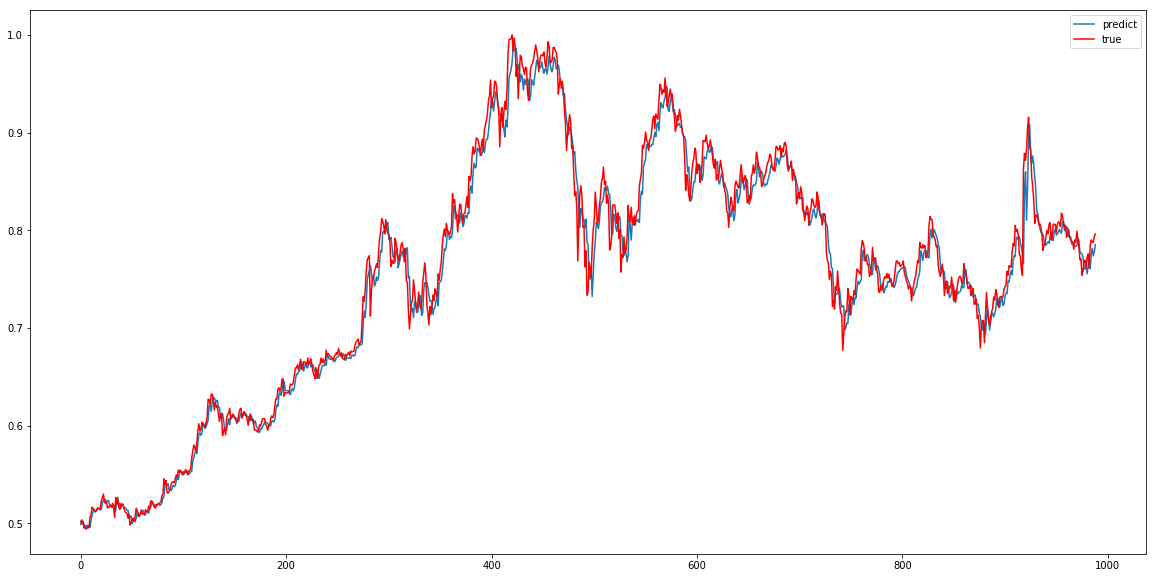

Test RMSE: 0.01564
Test MAE: 0.01124
Test MSE: 0.00024


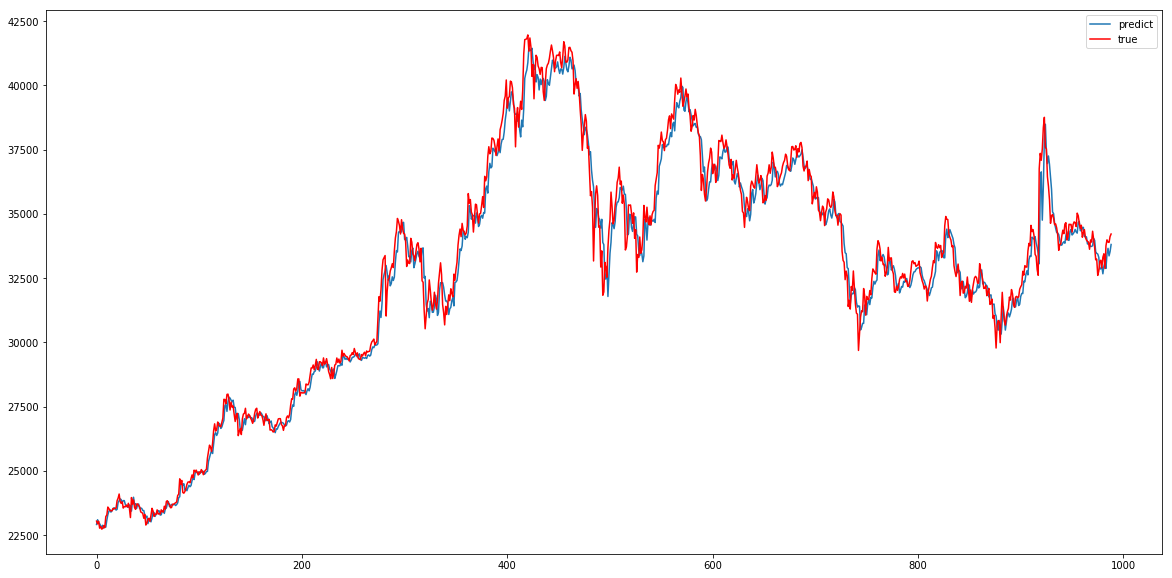

Test RMSE: 594.72420
Test MAE: 427.16519


In [86]:
## 1dcnn(5,1)-lstm

from matplotlib import pyplot
from sklearn.metrics import *

yhat = model.predict([testX])
yhat=yhat.reshape(-1,1)
plt.figure(figsize=(20,10))

pyplot.plot(yhat, label='predict')
pyplot.plot(testY,'r', label='true')
pyplot.legend()
pyplot.show()

from math import *
rmse = sqrt(mean_squared_error(testY, yhat))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, yhat)
print('Test MAE: %.5f' % mae)

mse = mean_squared_error(testY, yhat)
print('Test MSE: %.5f' % mse)

yhat_inverse = yhat*(np.max(values)-np.min(values))+np.min(values)
testY_inverse=testY*(np.max(values)-np.min(values))+np.min(values)

plt.figure(figsize=(20,10))

pyplot.plot(yhat_inverse, label='predict')
pyplot.plot(testY_inverse,'r', label='true')
pyplot.legend()
pyplot.show()

rmse = sqrt(mean_squared_error(yhat_inverse, testY_inverse))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(yhat_inverse, testY_inverse)
print('Test MAE: %.5f' % mae)

### Timedistributed LSTM-CNN

In [58]:
trainX = np.reshape(trainX, (trainX.shape[0],1, trainX.shape[1], trainX.shape[2]))
valX = np.reshape(valX, (valX.shape[0],1, valX.shape[1],valX.shape[2]))
testX = np.reshape(testX, (testX.shape[0],1,testX.shape[1], testX.shape[2] ))

In [59]:
from tensorflow.keras.models import *

first_input = Input(shape=(None,12,4))

in1=TimeDistributed(LSTM(units =150 , return_sequences=True))(first_input)

in0=TimeDistributed(Conv1D(filters=64, kernel_size=5, activation='relu'))(in1)
#in1= BatchNormalization(scale=False)(in1)
#in0=TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'))(in1)
#in1= BatchNormalization(scale=False)(in0)

in1=TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'))(in0)

#in1=add([in0,in1])
in1=TimeDistributed(MaxPooling1D(pool_size=2,name='extractor'))(in1)

in1=TimeDistributed(Flatten())(in1)

#model.add(LSTM(units = 128, return_sequences=True))
#in1=LSTM(units =150 , return_sequences=False)(in1)
#lstm_out=Bidirectional(LSTM(units =100 , return_sequences=False))(lstm_out)

#attn_layer = AttentionLayer(name='attention_layer')
#attn_out, attn_states = attn_layer([in1, in1])

    # Concat attention input and LSTM output, in original code it was decoder LSTM
#concat_out = Concatenate(axis=-1, name='concat_layer')([in1, attn_out])
#in1=MaxPooling1D(pool_size=2)(in1)

#flat_out = Flatten()(in1)
#flat_out=Dense(20, activation='relu')(flat_out)
#model.add(Dropout(drop_dense))
out1=Dense(1, activation = 'relu')(in1)
model=Model(inputs=first_input, outputs=out1)
model.compile(optimizer='adam', loss='mse')

checkpoint_path = "saved_weights/btc_timelstmcnn15051.hdf5"
cb = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_best_only=True,
                                        monitor='val_loss',mode='min',
                                                 verbose=1)


In [60]:
model.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, None, 12, 4)]     0         
_________________________________________________________________
time_distributed_5 (TimeDist (None, None, 12, 150)     93000     
_________________________________________________________________
time_distributed_6 (TimeDist (None, None, 8, 64)       48064     
_________________________________________________________________
time_distributed_7 (TimeDist (None, None, 8, 64)       4160      
_________________________________________________________________
time_distributed_8 (TimeDist (None, None, 4, 64)       0         
_________________________________________________________________
time_distributed_9 (TimeDist (None, None, 256)         0         
_________________________________________________________________
dense_8 (Dense)              (None, None, 1)           257 

In [61]:
## timedistribute lstm(100)-1dcnn

history=model.fit(trainX, trainY, epochs=500, batch_size=100, validation_data=(valX, valY), verbose=1, callbacks=[cb])

Train on 7992 samples, validate on 988 samples
Epoch 1/500
7600/7992 [===========================>..] - ETA: 0s - loss: 0.0066
Epoch 00001: val_loss improved from inf to 0.00009, saving model to saved_weights/btc_timelstmcnn15051.hdf5
7992/7992 [==============================] - 2s 295us/sample - loss: 0.0063 - val_loss: 8.7779e-05
Epoch 2/500
7600/7992 [===========================>..] - ETA: 0s - loss: 1.5365e-05
Epoch 00002: val_loss improved from 0.00009 to 0.00007, saving model to saved_weights/btc_timelstmcnn15051.hdf5
7992/7992 [==============================] - 1s 130us/sample - loss: 1.5299e-05 - val_loss: 7.4714e-05
Epoch 3/500
7600/7992 [===========================>..] - ETA: 0s - loss: 1.4275e-05
Epoch 00003: val_loss did not improve from 0.00007
7992/7992 [==============================] - 1s 127us/sample - loss: 1.4482e-05 - val_loss: 8.1972e-05
Epoch 4/500
7600/7992 [===========================>..] - ETA: 0s - loss: 1.4418e-05
Epoch 00004: val_loss did not improve from 0.

7600/7992 [===========================>..] - ETA: 0s - loss: 4.4545e-06
Epoch 00066: val_loss improved from 0.00003 to 0.00002, saving model to saved_weights/btc_timelstmcnn15051.hdf5
7992/7992 [==============================] - 1s 130us/sample - loss: 4.4319e-06 - val_loss: 2.3323e-05
Epoch 67/500
7500/7992 [===========================>..] - ETA: 0s - loss: 4.2562e-06
Epoch 00067: val_loss did not improve from 0.00002
7992/7992 [==============================] - 1s 128us/sample - loss: 4.4418e-06 - val_loss: 7.9263e-05
Epoch 68/500
7600/7992 [===========================>..] - ETA: 0s - loss: 5.1003e-06
Epoch 00068: val_loss did not improve from 0.00002
7992/7992 [==============================] - 1s 128us/sample - loss: 5.0474e-06 - val_loss: 2.9409e-05
Epoch 69/500
7600/7992 [===========================>..] - ETA: 0s - loss: 6.1647e-06
Epoch 00069: val_loss did not improve from 0.00002
7992/7992 [==============================] - 1s 128us/sample - loss: 6.1135e-06 - val_loss: 3.4487e

Epoch 100/500
7600/7992 [===========================>..] - ETA: 0s - loss: 4.3146e-06
Epoch 00100: val_loss did not improve from 0.00002
7992/7992 [==============================] - 1s 127us/sample - loss: 4.3722e-06 - val_loss: 6.3380e-05
Epoch 101/500
7600/7992 [===========================>..] - ETA: 0s - loss: 4.3996e-06
Epoch 00101: val_loss did not improve from 0.00002
7992/7992 [==============================] - 1s 128us/sample - loss: 4.3314e-06 - val_loss: 6.0241e-05
Epoch 102/500
7600/7992 [===========================>..] - ETA: 0s - loss: 4.6931e-06
Epoch 00102: val_loss did not improve from 0.00002
7992/7992 [==============================] - 1s 128us/sample - loss: 4.7646e-06 - val_loss: 3.3265e-05
Epoch 103/500
7600/7992 [===========================>..] - ETA: 0s - loss: 3.8254e-06
Epoch 00103: val_loss did not improve from 0.00002
7992/7992 [==============================] - 1s 127us/sample - loss: 3.7706e-06 - val_loss: 2.8591e-05
Epoch 104/500
7600/7992 [===============

Epoch 134/500
7600/7992 [===========================>..] - ETA: 0s - loss: 3.8564e-06
Epoch 00134: val_loss did not improve from 0.00002
7992/7992 [==============================] - 1s 128us/sample - loss: 3.8791e-06 - val_loss: 2.6503e-05
Epoch 135/500
7600/7992 [===========================>..] - ETA: 0s - loss: 3.6719e-06
Epoch 00135: val_loss did not improve from 0.00002
7992/7992 [==============================] - 1s 127us/sample - loss: 3.6446e-06 - val_loss: 2.8661e-05
Epoch 136/500
7600/7992 [===========================>..] - ETA: 0s - loss: 3.8404e-06
Epoch 00136: val_loss improved from 0.00002 to 0.00002, saving model to saved_weights/btc_timelstmcnn15051.hdf5
7992/7992 [==============================] - 1s 130us/sample - loss: 3.8419e-06 - val_loss: 1.6353e-05
Epoch 137/500
7600/7992 [===========================>..] - ETA: 0s - loss: 4.5429e-06- ETA: 0s - lo
Epoch 00137: val_loss did not improve from 0.00002
7992/7992 [==============================] - 1s 128us/sample - loss:

Epoch 168/500
7600/7992 [===========================>..] - ETA: 0s - loss: 3.4373e-06
Epoch 00168: val_loss did not improve from 0.00002
7992/7992 [==============================] - 1s 128us/sample - loss: 3.4292e-06 - val_loss: 2.0408e-05
Epoch 169/500
7600/7992 [===========================>..] - ETA: 0s - loss: 3.9957e-06
Epoch 00169: val_loss did not improve from 0.00002
7992/7992 [==============================] - 1s 129us/sample - loss: 3.9705e-06 - val_loss: 2.3028e-05
Epoch 170/500
7600/7992 [===========================>..] - ETA: 0s - loss: 3.6323e-06
Epoch 00170: val_loss did not improve from 0.00002
7992/7992 [==============================] - 1s 128us/sample - loss: 3.5999e-06 - val_loss: 5.7255e-05
Epoch 171/500
7600/7992 [===========================>..] - ETA: 0s - loss: 3.7014e-06
Epoch 00171: val_loss did not improve from 0.00002
7992/7992 [==============================] - 1s 128us/sample - loss: 3.6962e-06 - val_loss: 2.6410e-05
Epoch 172/500
7600/7992 [===============

Epoch 202/500
7600/7992 [===========================>..] - ETA: 0s - loss: 3.9987e-06
Epoch 00202: val_loss did not improve from 0.00002
7992/7992 [==============================] - 1s 129us/sample - loss: 3.9996e-06 - val_loss: 3.7585e-05
Epoch 203/500
7600/7992 [===========================>..] - ETA: 0s - loss: 3.5423e-06
Epoch 00203: val_loss did not improve from 0.00002
7992/7992 [==============================] - 1s 128us/sample - loss: 3.6372e-06 - val_loss: 1.5509e-05
Epoch 204/500
7600/7992 [===========================>..] - ETA: 0s - loss: 3.9870e-06
Epoch 00204: val_loss did not improve from 0.00002
7992/7992 [==============================] - 1s 128us/sample - loss: 4.1851e-06 - val_loss: 2.5556e-05
Epoch 205/500
7600/7992 [===========================>..] - ETA: 0s - loss: 3.6639e-06
Epoch 00205: val_loss did not improve from 0.00002
7992/7992 [==============================] - 1s 128us/sample - loss: 3.8447e-06 - val_loss: 1.9155e-05
Epoch 206/500
7600/7992 [===============

Epoch 270/500
7600/7992 [===========================>..] - ETA: 0s - loss: 3.2533e-06
Epoch 00270: val_loss did not improve from 0.00001
7992/7992 [==============================] - 1s 127us/sample - loss: 3.1967e-06 - val_loss: 1.6718e-05
Epoch 271/500
7600/7992 [===========================>..] - ETA: 0s - loss: 3.5925e-06
Epoch 00271: val_loss improved from 0.00001 to 0.00001, saving model to saved_weights/btc_timelstmcnn15051.hdf5
7992/7992 [==============================] - 1s 129us/sample - loss: 3.6608e-06 - val_loss: 1.4498e-05
Epoch 272/500
7600/7992 [===========================>..] - ETA: 0s - loss: 3.4121e-06
Epoch 00272: val_loss did not improve from 0.00001
7992/7992 [==============================] - 1s 128us/sample - loss: 3.3736e-06 - val_loss: 2.1516e-05
Epoch 273/500
7600/7992 [===========================>..] - ETA: 0s - loss: 3.3002e-06
Epoch 00273: val_loss did not improve from 0.00001
7992/7992 [==============================] - 1s 128us/sample - loss: 3.2375e-06 - 

Epoch 304/500
7500/7992 [===========================>..] - ETA: 0s - loss: 3.2118e-06
Epoch 00304: val_loss did not improve from 0.00001
7992/7992 [==============================] - 1s 128us/sample - loss: 3.2745e-06 - val_loss: 2.0259e-05
Epoch 305/500
7600/7992 [===========================>..] - ETA: 0s - loss: 3.3743e-06
Epoch 00305: val_loss did not improve from 0.00001
7992/7992 [==============================] - 1s 128us/sample - loss: 3.5561e-06 - val_loss: 1.8281e-05
Epoch 306/500
7600/7992 [===========================>..] - ETA: 0s - loss: 3.3074e-06
Epoch 00306: val_loss did not improve from 0.00001
7992/7992 [==============================] - 1s 128us/sample - loss: 3.2706e-06 - val_loss: 3.8210e-05
Epoch 307/500
7600/7992 [===========================>..] - ETA: 0s - loss: 3.3223e-06
Epoch 00307: val_loss did not improve from 0.00001
7992/7992 [==============================] - 1s 128us/sample - loss: 3.3360e-06 - val_loss: 1.8800e-05
Epoch 308/500
7600/7992 [===============

Epoch 338/500
7600/7992 [===========================>..] - ETA: 0s - loss: 3.0828e-06
Epoch 00338: val_loss did not improve from 0.00001
7992/7992 [==============================] - 1s 127us/sample - loss: 3.0433e-06 - val_loss: 1.5533e-05
Epoch 339/500
7600/7992 [===========================>..] - ETA: 0s - loss: 3.2500e-06
Epoch 00339: val_loss did not improve from 0.00001
7992/7992 [==============================] - 1s 128us/sample - loss: 3.2243e-06 - val_loss: 1.6163e-05
Epoch 340/500
7600/7992 [===========================>..] - ETA: 0s - loss: 3.7061e-06
Epoch 00340: val_loss improved from 0.00001 to 0.00001, saving model to saved_weights/btc_timelstmcnn15051.hdf5
7992/7992 [==============================] - 1s 129us/sample - loss: 3.6571e-06 - val_loss: 1.4333e-05
Epoch 341/500
7600/7992 [===========================>..] - ETA: 0s - loss: 3.3755e-06
Epoch 00341: val_loss did not improve from 0.00001
7992/7992 [==============================] - 1s 129us/sample - loss: 3.3118e-06 - 

Epoch 372/500
7600/7992 [===========================>..] - ETA: 0s - loss: 3.3841e-06
Epoch 00372: val_loss did not improve from 0.00001
7992/7992 [==============================] - 1s 128us/sample - loss: 3.3596e-06 - val_loss: 1.8291e-05
Epoch 373/500
7600/7992 [===========================>..] - ETA: 0s - loss: 3.2782e-06
Epoch 00373: val_loss did not improve from 0.00001
7992/7992 [==============================] - 1s 128us/sample - loss: 3.4838e-06 - val_loss: 4.7663e-05
Epoch 374/500
7600/7992 [===========================>..] - ETA: 0s - loss: 3.1171e-06
Epoch 00374: val_loss did not improve from 0.00001
7992/7992 [==============================] - 1s 127us/sample - loss: 3.1187e-06 - val_loss: 1.7693e-05
Epoch 375/500
7600/7992 [===========================>..] - ETA: 0s - loss: 3.1329e-06
Epoch 00375: val_loss did not improve from 0.00001
7992/7992 [==============================] - 1s 128us/sample - loss: 3.1391e-06 - val_loss: 1.7726e-05
Epoch 376/500
7600/7992 [===============

7600/7992 [===========================>..] - ETA: 0s - loss: 3.3817e-06
Epoch 00440: val_loss did not improve from 0.00001
7992/7992 [==============================] - 1s 128us/sample - loss: 3.3190e-06 - val_loss: 1.5579e-05
Epoch 441/500
7600/7992 [===========================>..] - ETA: 0s - loss: 2.9195e-06
Epoch 00441: val_loss did not improve from 0.00001
7992/7992 [==============================] - 1s 127us/sample - loss: 2.9722e-06 - val_loss: 1.8242e-05
Epoch 442/500
7600/7992 [===========================>..] - ETA: 0s - loss: 3.1910e-06
Epoch 00442: val_loss did not improve from 0.00001
7992/7992 [==============================] - 1s 128us/sample - loss: 3.1324e-06 - val_loss: 1.5950e-05
Epoch 443/500
7600/7992 [===========================>..] - ETA: 0s - loss: 3.0436e-06
Epoch 00443: val_loss did not improve from 0.00001
7992/7992 [==============================] - 1s 127us/sample - loss: 3.0664e-06 - val_loss: 2.7938e-05
Epoch 444/500
7600/7992 [===========================>.

In [62]:
model.load_weights("saved_weights/btc_timelstmcnn15051.hdf5")

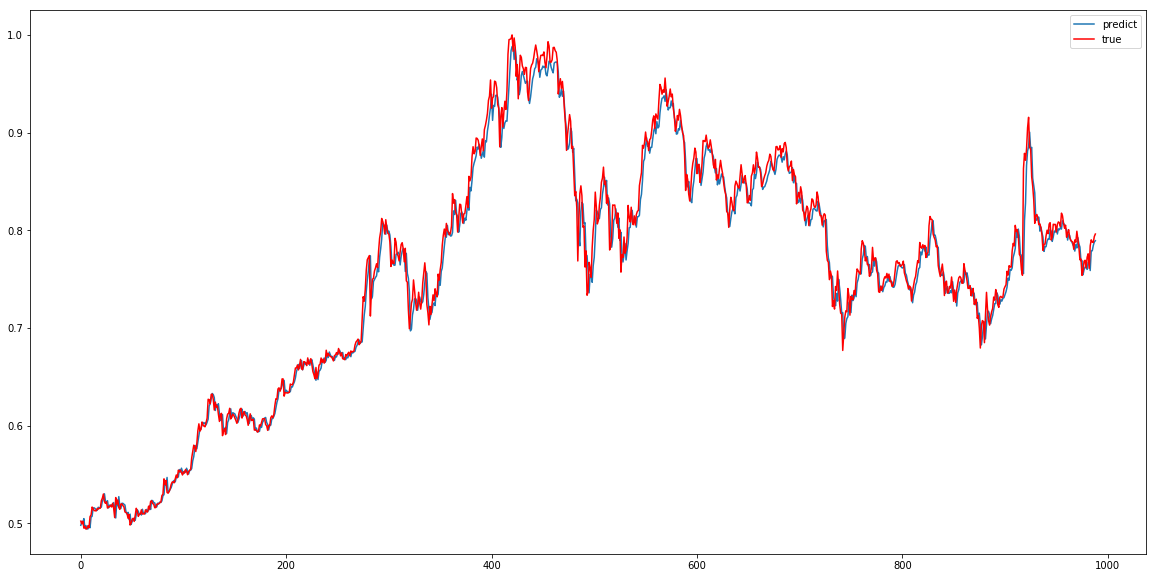

Test RMSE: 0.01382
Test MAE: 0.00973
Test MSE: 0.00019


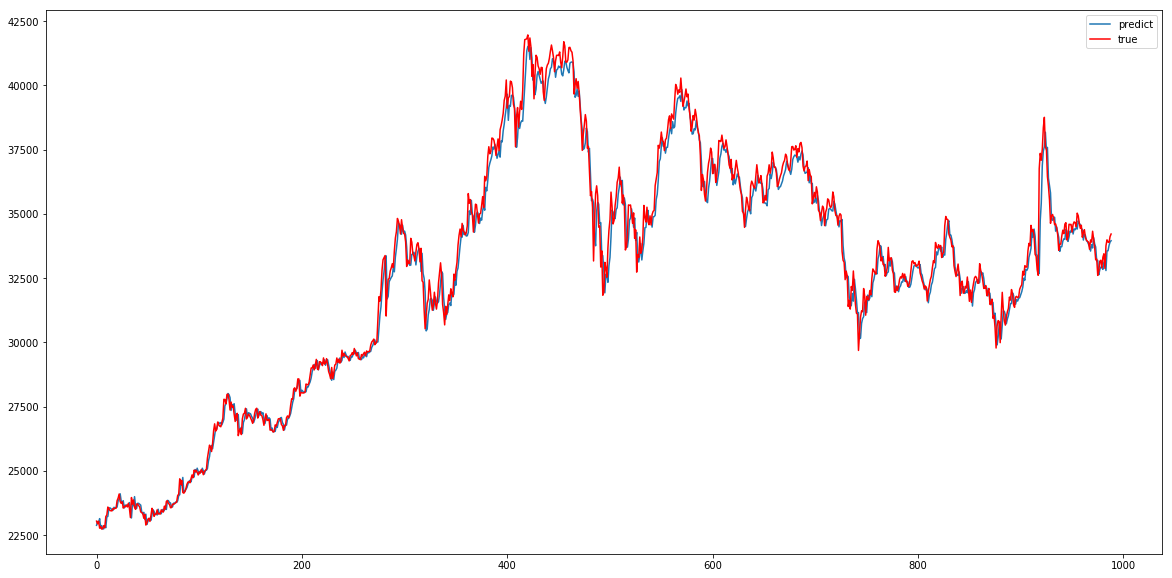

Test RMSE: 525.32457
Test MAE: 369.98352


In [63]:

## timedistributed lstm150-1dcnn(5,1)

from matplotlib import pyplot
from sklearn.metrics import *

yhat = model.predict([testX])
yhat=yhat.reshape(-1,1)
plt.figure(figsize=(20,10))

pyplot.plot(yhat, label='predict')
pyplot.plot(testY,'r', label='true')
pyplot.legend()
pyplot.show()

from math import *
rmse = sqrt(mean_squared_error(testY, yhat))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(testY, yhat)
print('Test MAE: %.5f' % mae)

mse = mean_squared_error(testY, yhat)
print('Test MSE: %.5f' % mse)

yhat_inverse = yhat*(np.max(values)-np.min(values))+np.min(values)
testY_inverse=testY*(np.max(values)-np.min(values))+np.min(values)

plt.figure(figsize=(20,10))

pyplot.plot(yhat_inverse, label='predict')
pyplot.plot(testY_inverse,'r', label='true')
pyplot.legend()
pyplot.show()

rmse = sqrt(mean_squared_error(yhat_inverse, testY_inverse))
print('Test RMSE: %.5f' % rmse)

mae = mean_absolute_error(yhat_inverse, testY_inverse)
print('Test MAE: %.5f' % mae)

### visualize

In [14]:
def gradient_importance(seq, model):

    seq = tf.Variable(seq[np.newaxis,:,:], dtype=tf.float32)

    with tf.GradientTape() as tape:
        predictions = model(seq)

    grads = tape.gradient(predictions, seq)
    grads = tf.reduce_mean(grads, axis=1).numpy()[0]
    
    return grads



def activation_grad(seq, model):
    
    seq = seq[np.newaxis,:,:]
    grad_model = Model([model.inputs], 
                       [model.get_layer('extractor').output, 
                        model.output])

    # Obtain the predicted value and the intermediate filters
    with tf.GradientTape() as tape:
        seq_outputs, predictions = grad_model(seq)

    # Extract filters and gradients
    output = seq_outputs[0]
    grads = tape.gradient(predictions, seq_outputs)[0]

    # Average gradients spatially
    weights = tf.reduce_mean(grads, axis=0)
    
    # Get a ponderated map of filters according to grad importance
    cam = np.ones(output.shape[0], dtype=np.float32)
    for index, w in enumerate(weights):
        cam += w * output[:, index]

    time = int(seq.shape[1]/output.shape[0])
    cam = zoom(cam.numpy(), time, order=1)
    heatmap = (cam - cam.min())/(cam.max() - cam.min())
    
    return heatmap

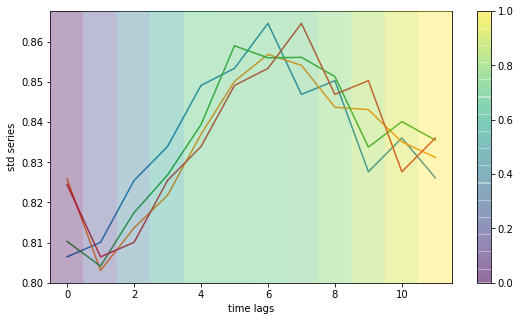

In [94]:
from scipy.ndimage import zoom
import random
id_=random.randint(0,len(testX))


X_test=testX.copy()
activation = activation_grad(X_test[id_], model)

plt.figure(figsize=(9,5))
plt.plot(X_test[id_])
#plt.plot(yhat, label='predict')
#plt.plot(testY, label='true')
plt.ylabel('std series'); plt.xlabel('time lags'); #plt.title(pd.to_datetime(test_date[sequence_length+id_]))
plt.twinx()
#plt.xticks(a)
plt.imshow(np.vstack([activation]*30), alpha=0.35)
plt.axis('off'); plt.colorbar()
np.set_printoptions(False)

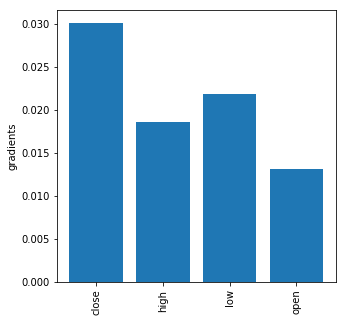

In [92]:
columns='close','high','low','open'

grad_imp = gradient_importance(X_test[id_], model)

plt.figure(figsize=(5,5))
plt.bar(range(len(grad_imp)), grad_imp)
plt.xticks(range(len(columns)), columns, rotation=90)
plt.ylabel('gradients'); #plt.title(pd.to_datetime(test_date[sequence_length+id_]))
np.set_printoptions(False)